# Surface Mass Balance: PCA 

Import relevant Libaries 

In [1]:
%pip install pyarrow
%pip install plotly
%pip install feature_engine
%pip update pandas

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
ERROR: unknown command "update"
Note: you may need to restart the kernel to use updated packages.


In [309]:
# Base libraries
import pandas as pd
import numpy as np
import os
import math as math
import datetime
from scipy import stats

# Visualizations
import matplotlib.pyplot as plt

import plotly.express as px
import plotly.graph_objects as go

import seaborn as sns

Set WD

#### Load KM_L 

In [329]:
df = pd.read_csv(r'..\data\promice\preprocessed\daily\KAN_L.csv', index_col=0)
# This bit to only focus on the time where we see Ice Ablation
#df = df[df["Ablation"] == True]

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5286 entries, 0 to 5285
Data columns (total 21 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   stid                                             5286 non-null   object 
 1   Datetime                                         5286 non-null   object 
 2   Air pressure (upper boom)                        5283 non-null   float64
 3   Air temperature (upper boom)                     5283 non-null   float64
 4   Relative humidity (upper boom) - corrected       5283 non-null   float64
 5   Specific humidity (upper boom)                   5283 non-null   float64
 6   Wind speed (upper boom)                          5279 non-null   float64
 7   Wind from direction (upper boom)                 5279 non-null   float64
 8   Downwelling shortwave radiation - corrected      5283 non-null   float64
 9   Upwelling shortwave radiation 

## PCA

##### Pre-processing

In [330]:
# This bit to change the datetime variables into a form that a ML models can understand
  # https://ianlondon.github.io/blog/encoding-cyclical-features-24hour-time/
  # https://feature-engine.trainindata.com/en/1.3.x/user_guide/creation/CyclicalFeatures.html


# This bit retrieve the indexes for all melting season categories and remove column from df
df['Datetime'] = pd.to_datetime(df['Datetime'])

periods = ['pre','beginning', 'middle','end']

for period in periods:
    exec(f"indices_{period} = df[df['Melting Season'] == '{period}'].index")

#df.drop(columns=['Melting Season'], inplace=True) 
indices_beginning

Int64Index([   0,    1,    2,  273,  274,  275,  276,  277,  278,  279,
            ...
            5030, 5031, 5032, 5033, 5034, 5035, 5036, 5037, 5038, 5039],
           dtype='int64', length=243)

**Splitting data in absolute and delta, as well as train test split** <br><br>
Technically unnecessary to split in absolute and delta since PCA does not care

In [350]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


df_absolute = df.drop('Surface height from combined measurements DELTA',axis=1)
df_absolute = df_absolute.loc[df_absolute['Surface height from combined measurements'].notna()]


X_absolute = df_absolute.loc[:, df_absolute.columns != "Surface height from combined measurements"] # All features except y
y_absolute = df_absolute["Surface height from combined measurements"]



# using the train test split function
X_absolute_train, X_absolute_test,y_absolute_train, y_absolute_test = train_test_split(X_absolute,y_absolute,
                                   test_size=0.2, 
                                   random_state=2023,
                                   shuffle=True)

# This bit to convert all numerical values into the same scale 
num_cols = X_absolute.select_dtypes(include=['int64','float64']).columns.to_list()
scaler = MinMaxScaler()
scaler = StandardScaler()


X_absolute_train[num_cols] = X_absolute_train[num_cols].ffill().bfill()
X_absolute_test[num_cols] = X_absolute_test[num_cols].ffill().bfill()

X_absolute_train[num_cols] = scaler.fit_transform(X_absolute_train[num_cols])
X_absolute_test[num_cols] = scaler.fit_transform(X_absolute_test[num_cols])


df_delta = df.drop('Surface height from combined measurements', axis=1)
df_delta = df_delta.loc[df_delta['Surface height from combined measurements DELTA'].notna()]


X_delta = df_delta.loc[:, df_absolute.columns != "Surface height from combined measurements"] # All features except y
y_delta = df_delta["Surface height from combined measurements DELTA"]

# using the train test split function
X_delta_train, X_delta_test,y_delta_train, y_delta_test = train_test_split(X_delta,y_delta,
                                   test_size=0.2, 
                                   random_state=2023,
                                   shuffle=True)

# This bit to convert all numerical values into the same scale 
num_cols = X_delta.select_dtypes(include=['int64','float64']).columns.to_list()
scaler = MinMaxScaler()
scaler = StandardScaler()


X_delta_train[num_cols] = X_delta_train[num_cols].ffill().bfill()
X_delta_test[num_cols] = X_delta_test[num_cols].ffill().bfill()

X_delta_train[num_cols] = scaler.fit_transform(X_delta_train[num_cols])
X_delta_test[num_cols] = scaler.fit_transform(X_delta_test[num_cols])



**PCA** - Plotting functions

In [356]:
def plot_cum_variance(x_vals, cum_var):
    plt.plot(x_vals, cum_var)
    plt.xlabel('Number of Component')
    plt.ylabel('Cumulative Variance Explained')
    plt.title(' The Optimal Number of PC')
    plt.show()

def plot_pca_loadings(labels_vals, loadings):
    fig, axes = plt.subplots(1, len(labels_vals), figsize=(len(labels_vals)*10, 10))

    for i, label in enumerate(labels_vals):
        pc_loadings = loadings.abs().sort_values(by=label, ascending=False)[[label]]
        pc_loadings = pc_loadings.reset_index()
        pc_loadings.columns = ['Attribute', 'CorrelationWithPC{}'.format(i+1)]
        axes[i].bar(x=pc_loadings['Attribute'], height=pc_loadings['CorrelationWithPC{}'.format(i+1)], color='#087E8B')
        axes[i].set_title('PCA loading scores (principal component {})'.format(i+1), size=10)
        axes[i].tick_params(axis='x', rotation=90)

    plt.show()

def plot_pca_vert(labels_vals,loadings, absolute=False):
    plt.style.use('ggplot')
    fig, axes = plt.subplots(nrows=1, ncols=len(loadings.columns), figsize=(15,5), sharey=True)
    if absolute:
        loadings = loadings.abs()
    loadings = loadings.sort_values(by=loadings.columns[0],ascending=True)
    for i, col in enumerate(loadings.columns):

        loadings[col].plot(kind='barh', ax=axes[i], color='#087E8B')
            
        axes[i].set_title(labels_vals[i], size=12)
        axes[i].set_ylabel('')
        axes[i].set_xlabel('Correlation', size=10)
        axes[i].tick_params(axis='y', rotation=0, labelsize=8)
        axes[i].set_yticks(np.arange(len(loadings.index)))
        axes[i].set_yticklabels(loadings.index, fontsize=8)
        axes[i].spines['right'].set_visible(False)
        axes[i].spines['top'].set_visible(False)
    

    plt.subplots_adjust(wspace=0.1)
    plt.show()


**PCA** - iterative function, cycling through absolute, delta, and all periods

pca all periods


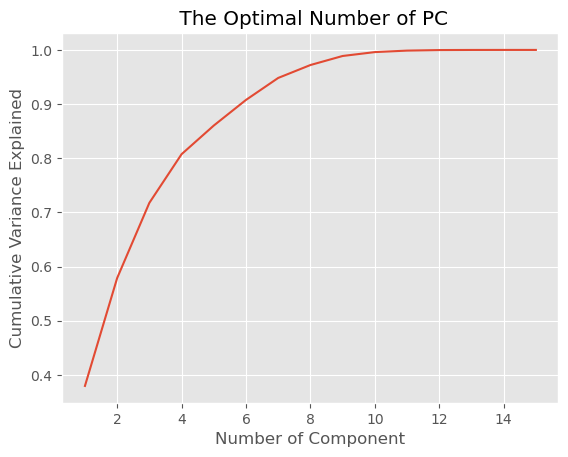

TESTING DELTA
-----------------------------------------------------------------------------------------


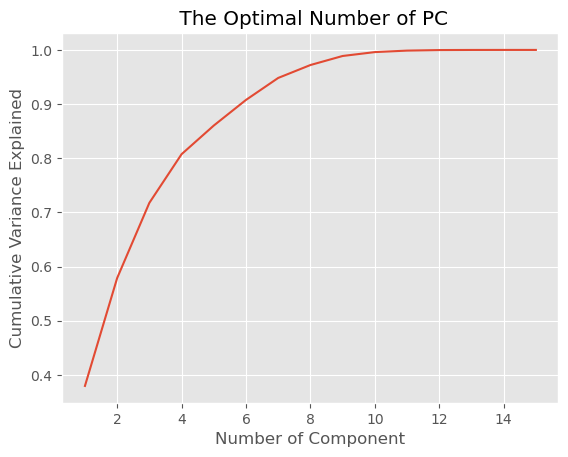

ALL PERIODS


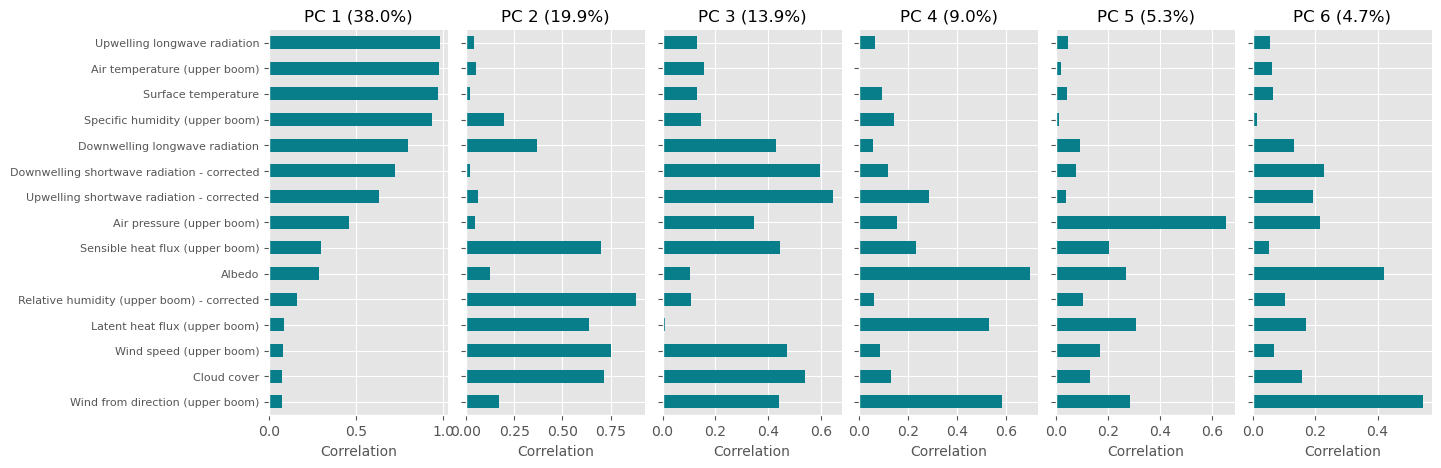

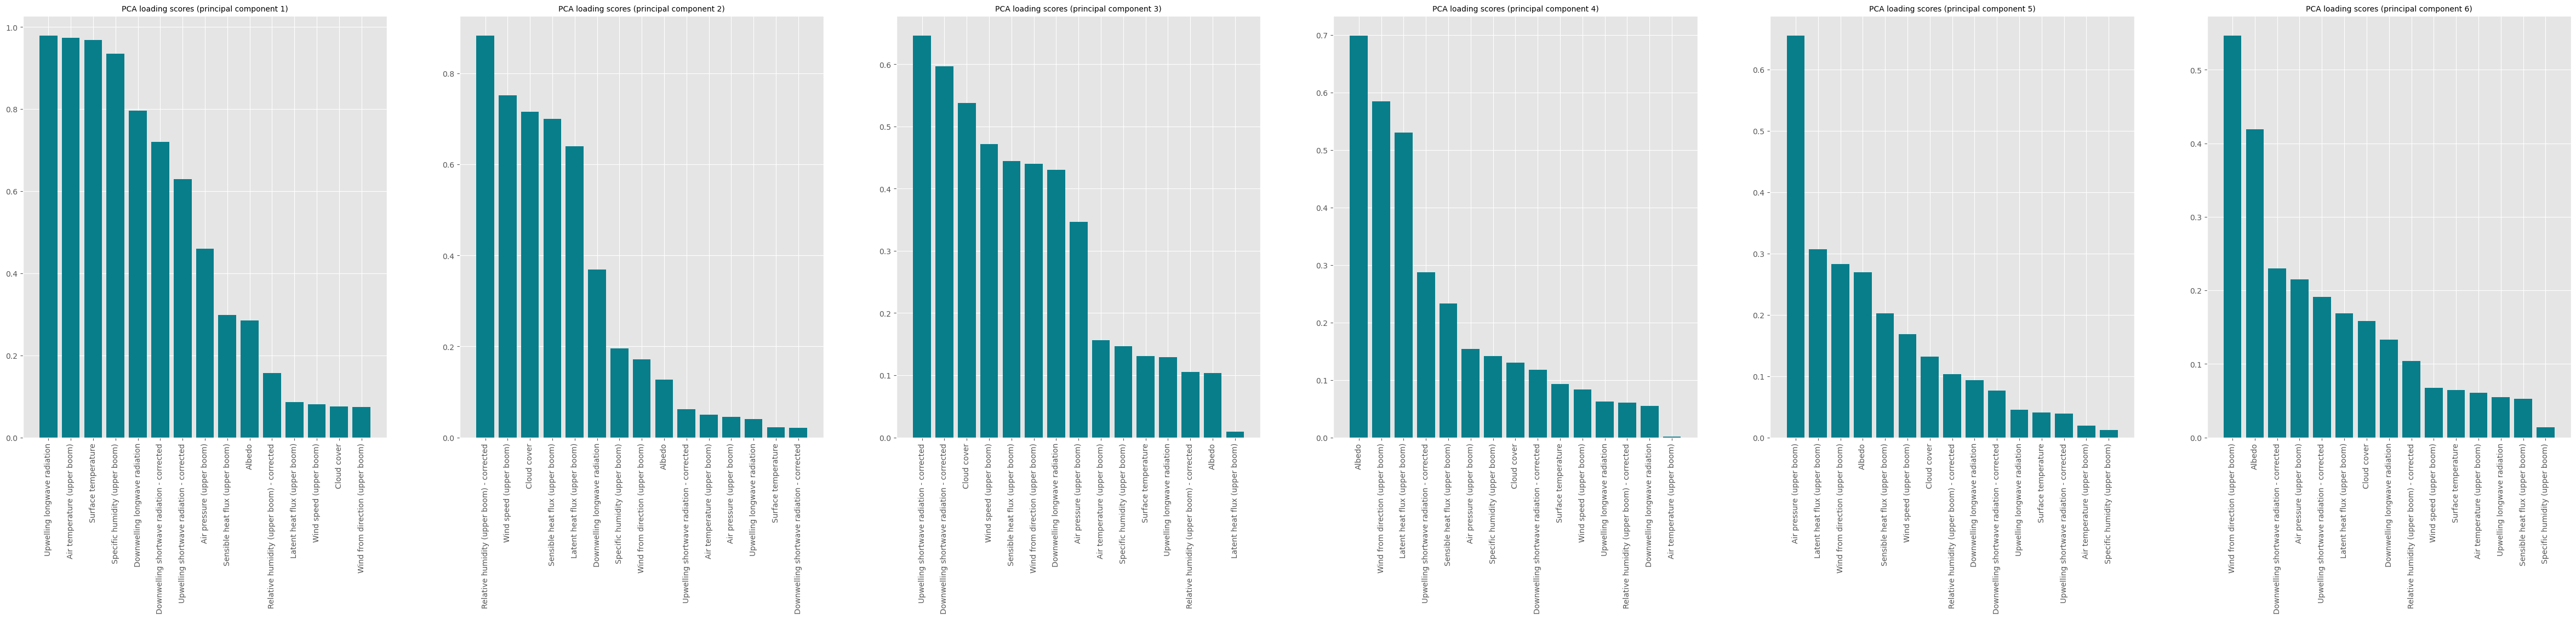

PCA  DELTA PRE
----------------------------------------------------------------------------------------


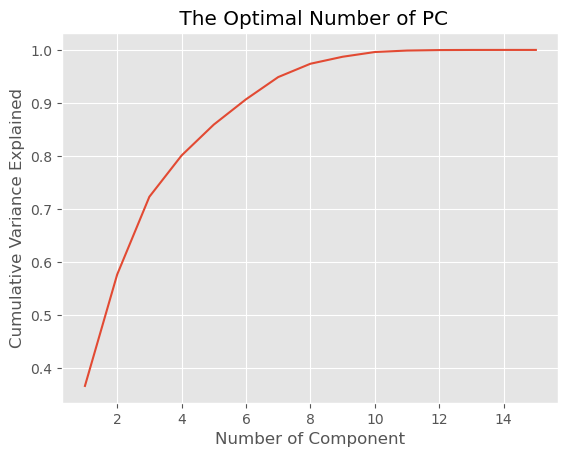

PC 1 (36.6%)  PC 2 (21.0%)  \
Air pressure (upper boom)                        0.430629     -0.322380   
Air temperature (upper boom)                     0.939138     -0.096837   
Relative humidity (upper boom) - corrected      -0.479338     -0.744735   
Specific humidity (upper boom)                   0.647554     -0.218631   
Wind speed (upper boom)                          0.515663      0.718579   
Wind from direction (upper boom)                 0.157776     -0.278577   
Downwelling shortwave radiation - corrected      0.519707     -0.349699   
Upwelling shortwave radiation - corrected        0.516436     -0.488821   
Downwelling longwave radiation                   0.626329     -0.378921   
Upwelling longwave radiation                     0.920042     -0.207286   
Surface temperature                              0.961657     -0.206655   
Latent heat flux (upper boom)                   -0.612151     -0.436161   
Sensible heat flux (upper boom)                  0.449968      0.737500   
Albedo                                          -0.046079     -0.391877   
Cloud cover                                     -0.249840     -0.527641   

                                             PC 3 (14.7%)  PC 4 (7.8%)  \
Air pressure (upper boom)                       -0.370964     0.469100   
Air temperature (upper boom)                     0.126558     0.111362   
Relative humidity (upper boom) - corrected       0.262750     0.222240   
Specific humidity (upper boom)                   0.133265     0.209829   
Wind speed (upper boom)                          0.272829    -0.066172   
Wind from direction (upper boom)                 0.607861    -0.460924   
Downwelling shortwave radiation - corrected     -0.539925    -0.158250   
Upwelling shortwave radiation - corrected       -0.613417    -0.280623   
Downwelling longwave radiation                   0.485813     0.071272   
Upwelling longwave radiation                     0.116417     0.068428   
Surface temperature                              0.114237     0.055521   
Latent heat flux (upper boom)                    0.047462     0.481276   
Sensible heat flux (upper boom)                  0.256304     0.216193   
Albedo                                          -0.056209    -0.442963   
Cloud cover                                      0.675504    -0.056058   

                                             PC 5 (5.8%)  PC 6 (4.8%)  
Air pressure (upper boom)                       0.558004     0.064921  
Air temperature (upper boom)                   -0.075027    -0.035296  
Relative humidity (upper boom) - corrected      0.051779     0.005693  
Specific humidity (upper boom)                 -0.055433    -0.034049  
Wind speed (upper boom)                         0.236564    -0.124209  
Wind from direction (upper boom)                0.477185     0.438053  
Downwelling shortwave radiation - corrected    -0.058327     0.092981  
Upwelling shortwave radiation - corrected      -0.002831     0.003875  
Downwelling longwave radiation                 -0.163313    -0.098242  
Upwelling longwave radiation                   -0.100043    -0.003372  
Surface temperature                            -0.095589    -0.001742  
Latent heat flux (upper boom)                   0.171260    -0.106747  
Sensible heat flux (upper boom)                 0.195225    -0.187191  
Albedo                                          0.311972    -0.634753  
Cloud cover                                    -0.172138    -0.122178

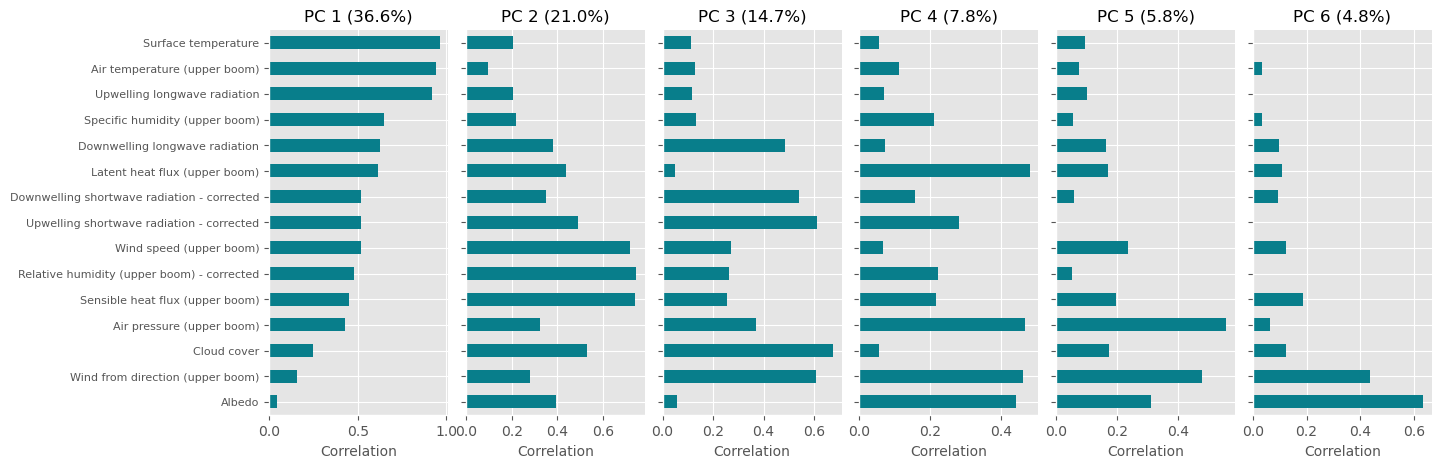

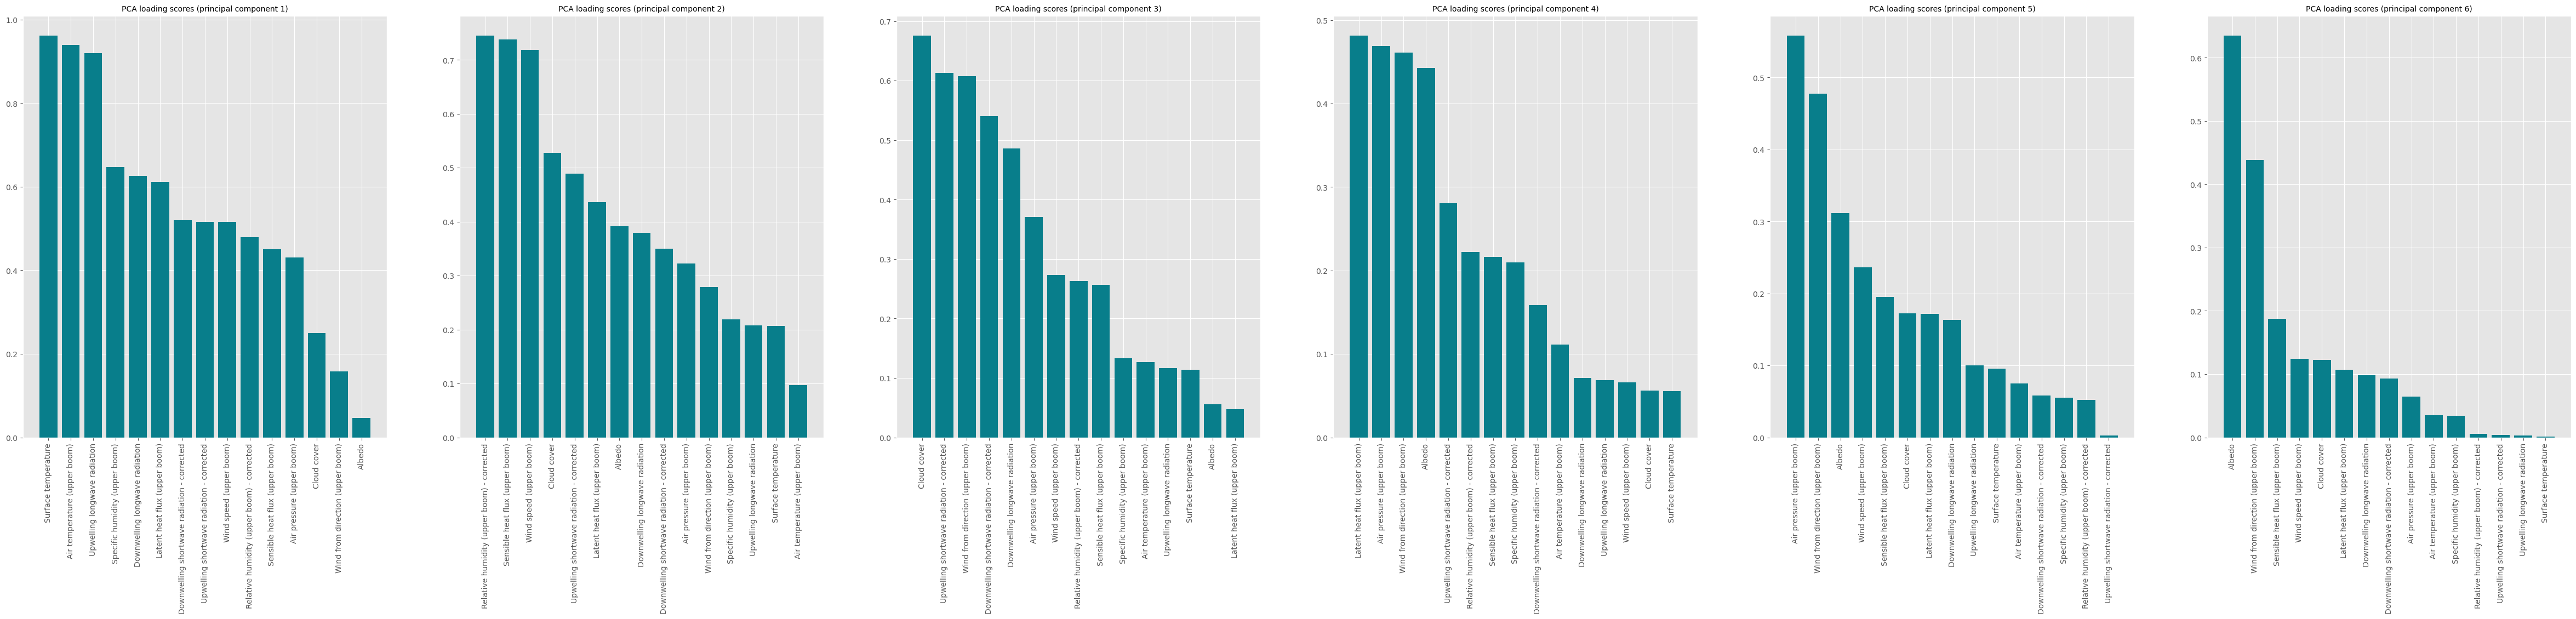

PCA  DELTA BEGINNING
----------------------------------------------------------------------------------------


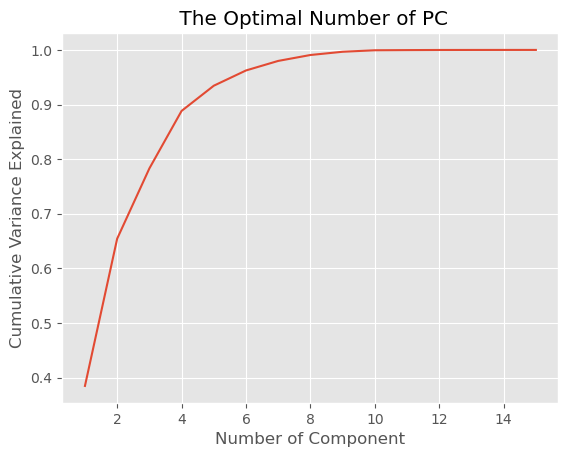

PC 1 (38.5%)  PC 2 (27.0%)  \
Air pressure (upper boom)                        0.098218     -0.080191   
Air temperature (upper boom)                     0.124195      0.150222   
Relative humidity (upper boom) - corrected      -0.734740     -0.013588   
Specific humidity (upper boom)                  -0.108775      0.240978   
Wind speed (upper boom)                          0.512355      0.284747   
Wind from direction (upper boom)                -0.194476      0.406228   
Downwelling shortwave radiation - corrected      0.327896     -0.400225   
Upwelling shortwave radiation - corrected        0.163294     -0.502623   
Downwelling longwave radiation                  -0.280445      0.452565   
Upwelling longwave radiation                     0.024471      0.084968   
Surface temperature                              0.009107      0.046351   
Latent heat flux (upper boom)                   -0.397427      0.288821   
Sensible heat flux (upper boom)                  0.949792      0.750471   
Albedo                                          -0.283883     -0.189125   
Cloud cover                                     -0.712821      0.526656   

                                             PC 3 (12.9%)  PC 4 (10.5%)  \
Air pressure (upper boom)                       -0.007963     -0.313447   
Air temperature (upper boom)                    -0.089450     -0.040708   
Relative humidity (upper boom) - corrected      -0.247502      0.277881   
Specific humidity (upper boom)                  -0.270099      0.054531   
Wind speed (upper boom)                          0.126391      0.129964   
Wind from direction (upper boom)                 0.399470      0.550097   
Downwelling shortwave radiation - corrected     -0.121990      0.172378   
Upwelling shortwave radiation - corrected        0.076519      0.240912   
Downwelling longwave radiation                   0.068218     -0.173014   
Upwelling longwave radiation                    -0.044265     -0.038470   
Surface temperature                             -0.034719     -0.025326   
Latent heat flux (upper boom)                   -0.596544      0.209650   
Sensible heat flux (upper boom)                 -0.081805      0.101020   
Albedo                                           0.365821      0.140355   
Cloud cover                                      0.272027     -0.238971   

                                             PC 5 (4.6%)  
Air pressure (upper boom)                       0.501201  
Air temperature (upper boom)                    0.022258  
Relative humidity (upper boom) - corrected     -0.004925  
Specific humidity (upper boom)                  0.014795  
Wind speed (upper boom)                        -0.059716  
Wind from direction (upper boom)                0.231894  
Downwelling shortwave radiation - corrected     0.086407  
Upwelling shortwave radiation - corrected       0.050620  
Downwelling longwave radiation                  0.011425  
Upwelling longwave radiation                    0.009222  
Surface temperature                             0.005852  
Latent heat flux (upper boom)                   0.078261  
Sensible heat flux (upper boom)                -0.012297  
Albedo                                         -0.048134  
Cloud cover                                    -0.024042

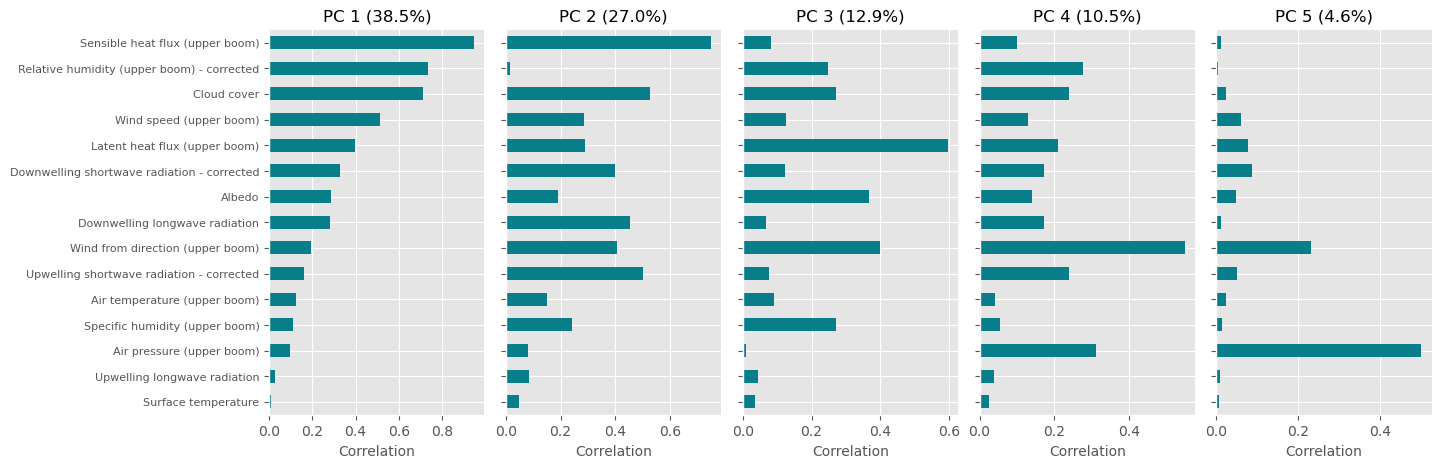

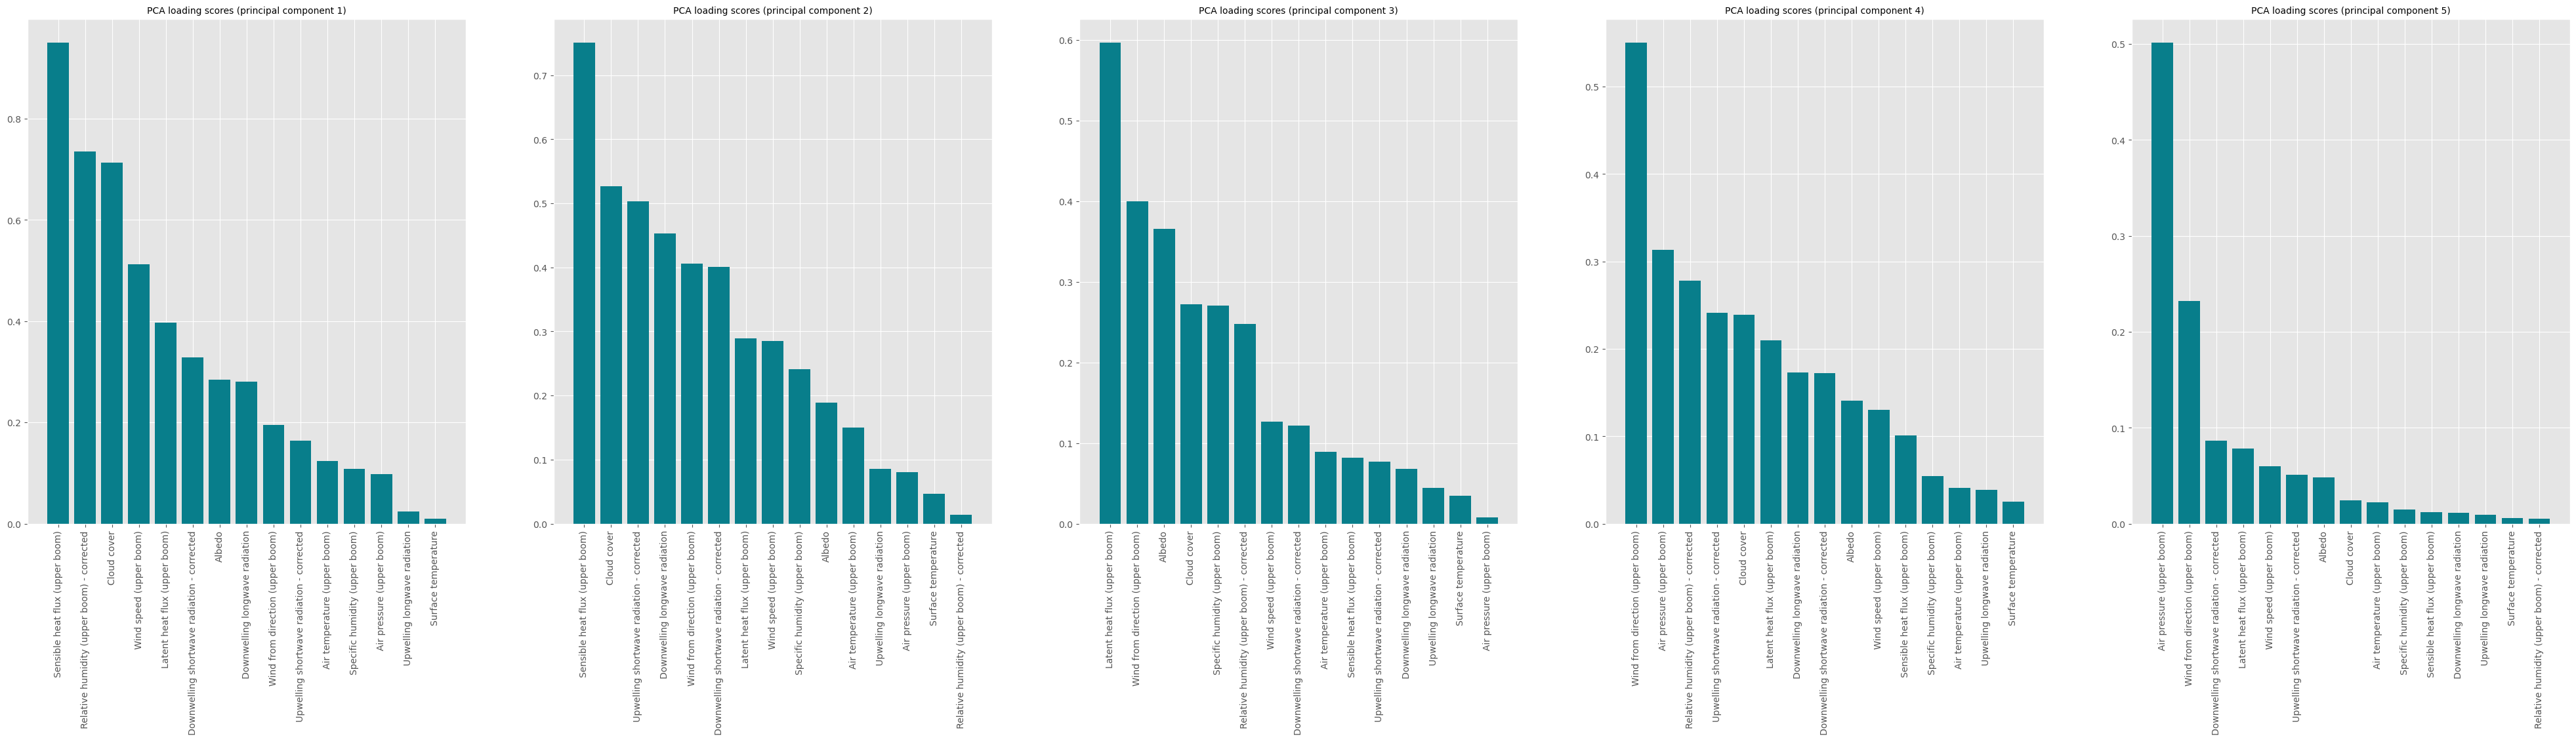

PCA  DELTA MIDDLE
----------------------------------------------------------------------------------------


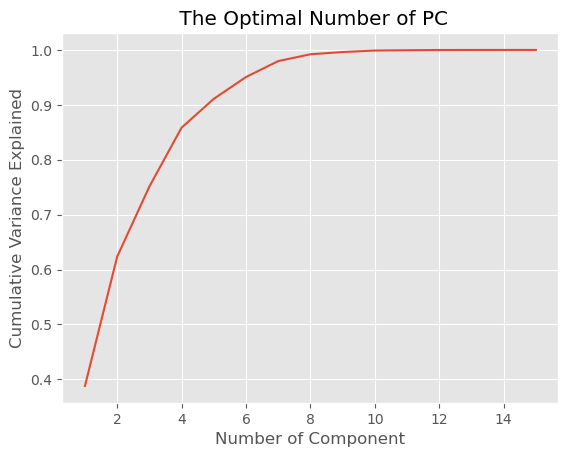

PC 1 (38.8%)  PC 2 (23.5%)  \
Air pressure (upper boom)                       -0.057430      0.129957   
Air temperature (upper boom)                    -0.000720      0.172250   
Relative humidity (upper boom) - corrected       0.624800     -0.247087   
Specific humidity (upper boom)                   0.291258      0.222789   
Wind speed (upper boom)                         -0.106078      0.440316   
Wind from direction (upper boom)                 0.325368     -0.133351   
Downwelling shortwave radiation - corrected     -0.546901      0.055470   
Upwelling shortwave radiation - corrected       -0.463804     -0.106968   
Downwelling longwave radiation                   0.507230      0.085257   
Upwelling longwave radiation                     0.027845      0.067730   
Surface temperature                              0.010056      0.026905   
Latent heat flux (upper boom)                    0.662302      0.516816   
Sensible heat flux (upper boom)                 -0.061586      0.861825   
Albedo                                           0.075482     -0.394053   
Cloud cover                                      0.892592     -0.153453   

                                             PC 3 (12.8%)  PC 4 (10.7%)  \
Air pressure (upper boom)                       -0.165538      0.113888   
Air temperature (upper boom)                    -0.010123     -0.030447   
Relative humidity (upper boom) - corrected      -0.277870      0.289565   
Specific humidity (upper boom)                  -0.148124      0.083085   
Wind speed (upper boom)                          0.239612     -0.011488   
Wind from direction (upper boom)                 0.633726      0.484472   
Downwelling shortwave radiation - corrected     -0.186638      0.271532   
Upwelling shortwave radiation - corrected       -0.091909      0.291625   
Downwelling longwave radiation                   0.035837     -0.170667   
Upwelling longwave radiation                    -0.008089     -0.017508   
Surface temperature                             -0.012390     -0.008828   
Latent heat flux (upper boom)                   -0.314480      0.342452   
Sensible heat flux (upper boom)                  0.267422     -0.029716   
Albedo                                           0.230261      0.113148   
Cloud cover                                      0.079886     -0.250649   

                                             PC 5 (5.3%)  
Air pressure (upper boom)                      -0.459084  
Air temperature (upper boom)                   -0.042937  
Relative humidity (upper boom) - corrected      0.100829  
Specific humidity (upper boom)                 -0.001218  
Wind speed (upper boom)                         0.073122  
Wind from direction (upper boom)               -0.122591  
Downwelling shortwave radiation - corrected    -0.120595  
Upwelling shortwave radiation - corrected      -0.049953  
Downwelling longwave radiation                 -0.141793  
Upwelling longwave radiation                   -0.041891  
Surface temperature                            -0.022481  
Latent heat flux (upper boom)                   0.130730  
Sensible heat flux (upper boom)                 0.031499  
Albedo                                          0.153567  
Cloud cover                                    -0.171900

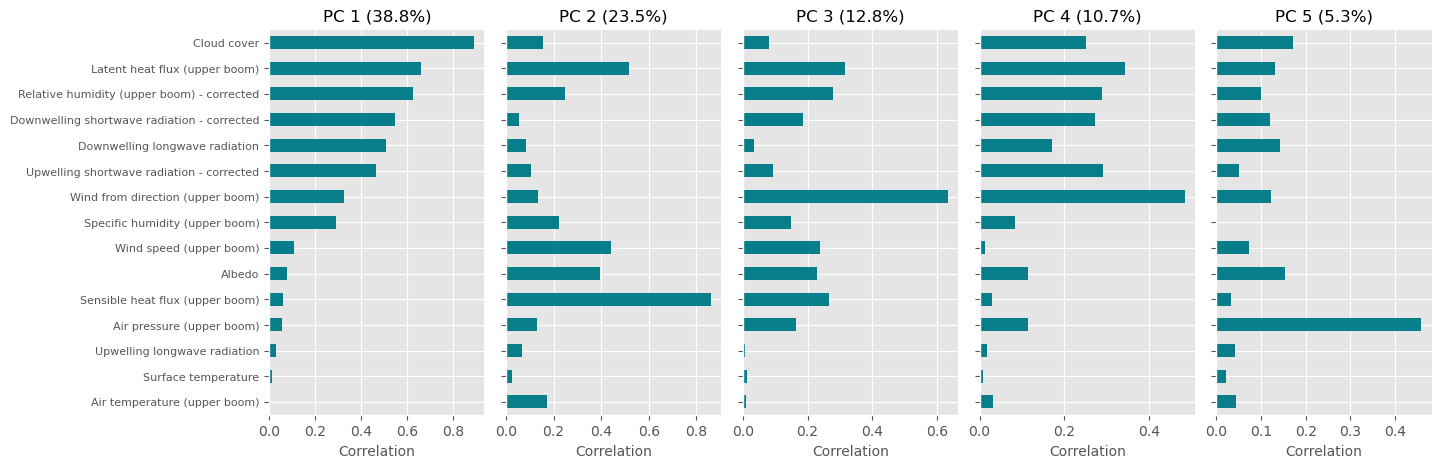

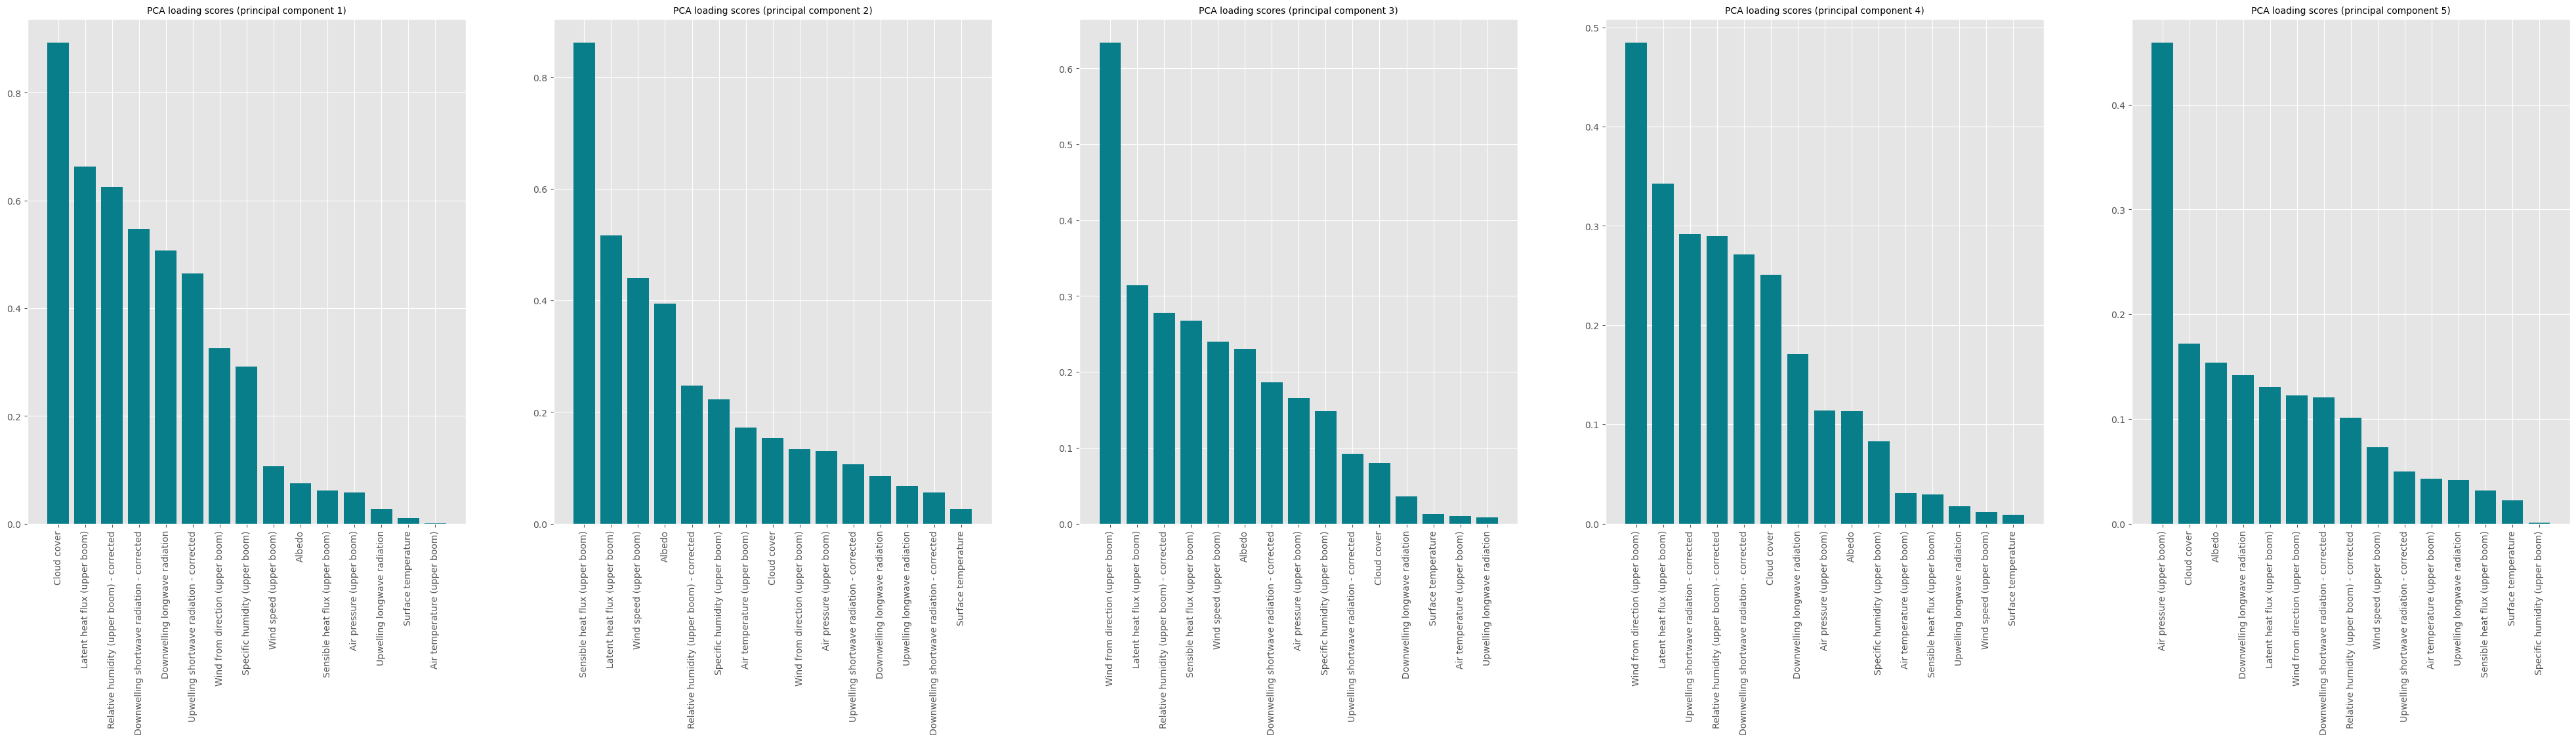

PCA  DELTA END
----------------------------------------------------------------------------------------


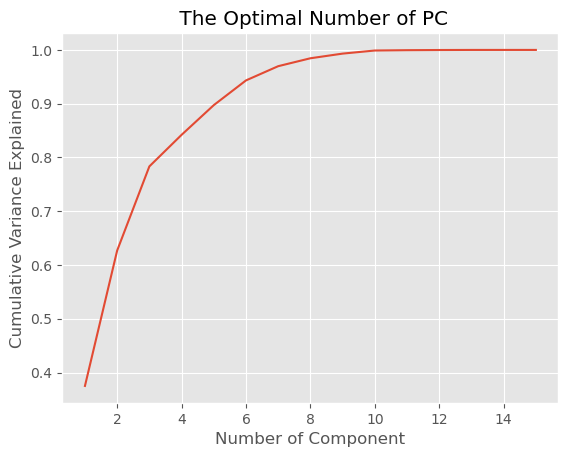

PC 1 (37.5%)  PC 2 (25.2%)  \
Air pressure (upper boom)                        0.027378     -0.104626   
Air temperature (upper boom)                    -0.056186      0.339763   
Relative humidity (upper boom) - corrected      -0.836259     -0.174027   
Specific humidity (upper boom)                  -0.359311      0.463130   
Wind speed (upper boom)                          0.373124      0.549853   
Wind from direction (upper boom)                -0.557004      0.002405   
Downwelling shortwave radiation - corrected      0.230419     -0.107049   
Upwelling shortwave radiation - corrected        0.235125     -0.262188   
Downwelling longwave radiation                  -0.603449      0.394997   
Upwelling longwave radiation                    -0.133701      0.301300   
Surface temperature                             -0.104955      0.245459   
Latent heat flux (upper boom)                   -0.706719      0.042243   
Sensible heat flux (upper boom)                  0.330847      0.793891   
Albedo                                          -0.159496     -0.732670   
Cloud cover                                     -0.963011      0.124539   

                                             PC 3 (15.6%)  PC 4 (5.9%)  \
Air pressure (upper boom)                       -0.287460     0.349460   
Air temperature (upper boom)                    -0.011408    -0.073503   
Relative humidity (upper boom) - corrected      -0.178622     0.055061   
Specific humidity (upper boom)                  -0.110481    -0.050193   
Wind speed (upper boom)                          0.365796     0.202449   
Wind from direction (upper boom)                 0.693162     0.136953   
Downwelling shortwave radiation - corrected     -0.103235    -0.005162   
Upwelling shortwave radiation - corrected       -0.022406     0.049726   
Downwelling longwave radiation                   0.086422    -0.130400   
Upwelling longwave radiation                    -0.007092    -0.113678   
Surface temperature                             -0.000147    -0.120639   
Latent heat flux (upper boom)                   -0.476563     0.399360   
Sensible heat flux (upper boom)                  0.208354     0.288861   
Albedo                                           0.579343     0.165500   
Cloud cover                                      0.171669    -0.115334   

                                             PC 5 (5.5%)  PC 6 (4.6%)  
Air pressure (upper boom)                       0.342620     0.340181  
Air temperature (upper boom)                    0.114512     0.082306  
Relative humidity (upper boom) - corrected     -0.010744    -0.027761  
Specific humidity (upper boom)                  0.118962     0.077060  
Wind speed (upper boom)                        -0.119242     0.025867  
Wind from direction (upper boom)                0.379624    -0.296387  
Downwelling shortwave radiation - corrected     0.172978     0.013211  
Upwelling shortwave radiation - corrected       0.149979     0.066873  
Downwelling longwave radiation                  0.004770     0.175558  
Upwelling longwave radiation                    0.140175     0.089493  
Surface temperature                             0.140539     0.083208  
Latent heat flux (upper boom)                  -0.144079    -0.181828  
Sensible heat flux (upper boom)                -0.139690     0.053175  
Albedo                                         -0.166891     0.273853  
Cloud cover                                    -0.172148     0.176011

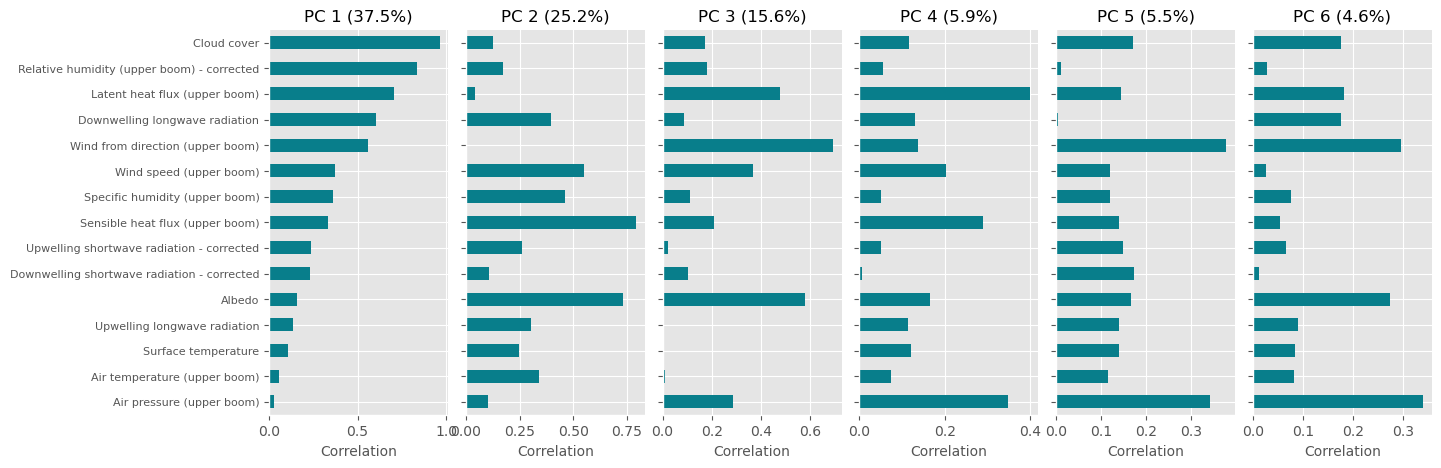

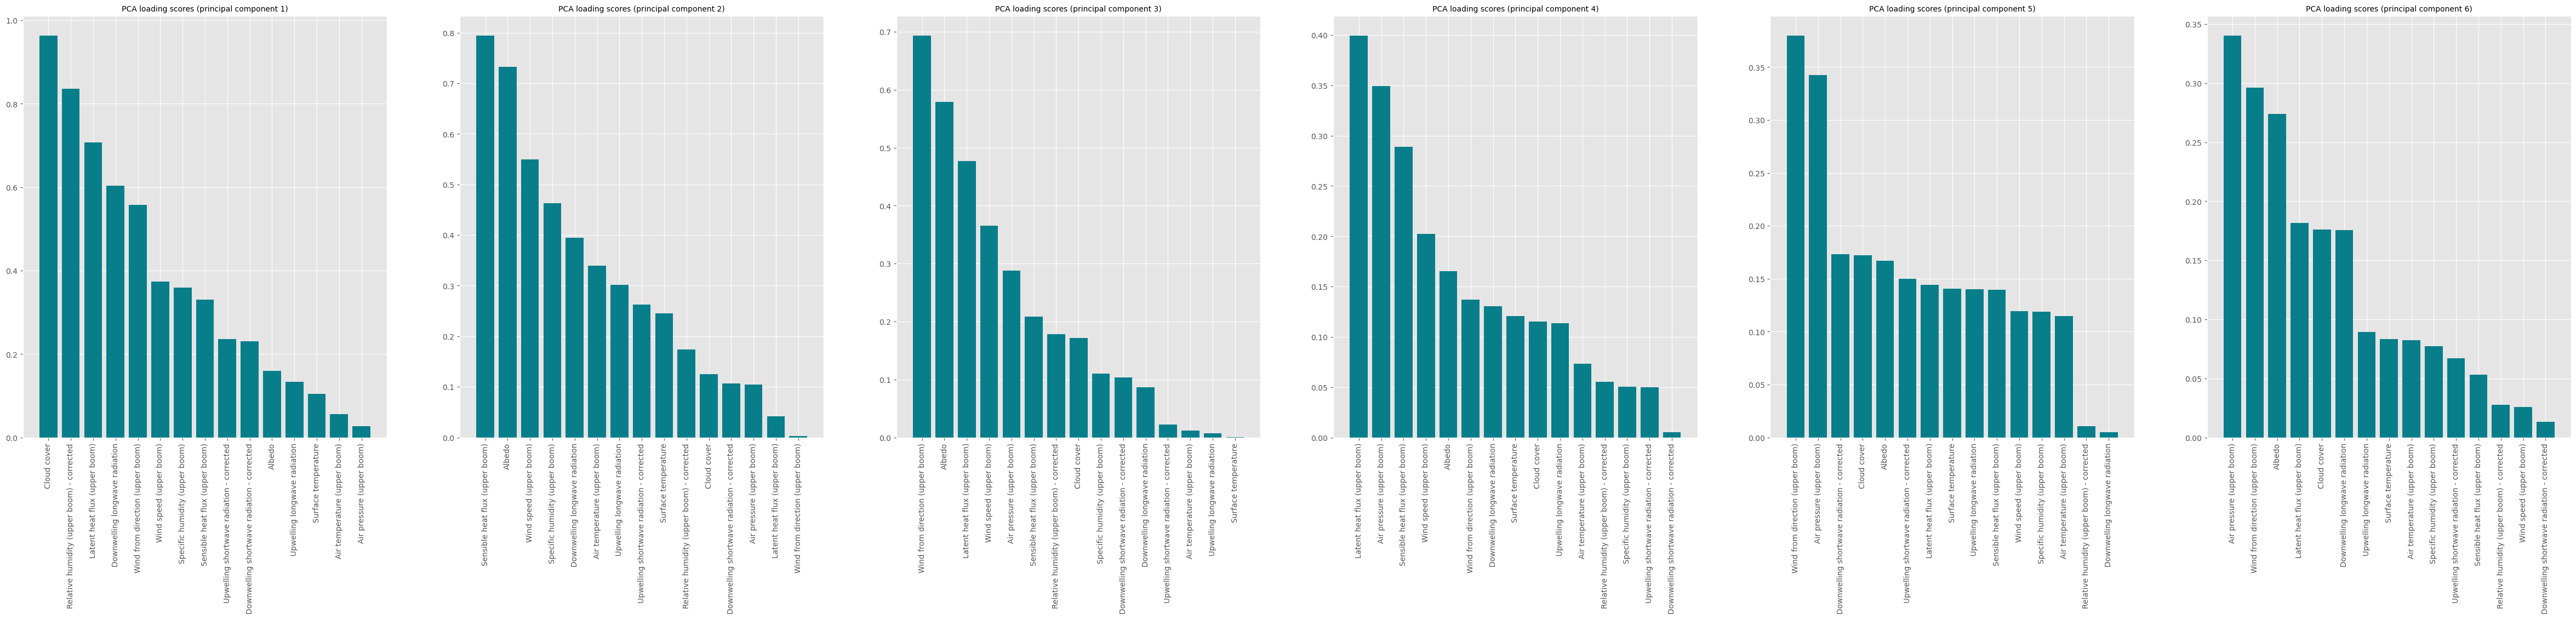

TESTING ABSOLUTE
-----------------------------------------------------------------------------------------


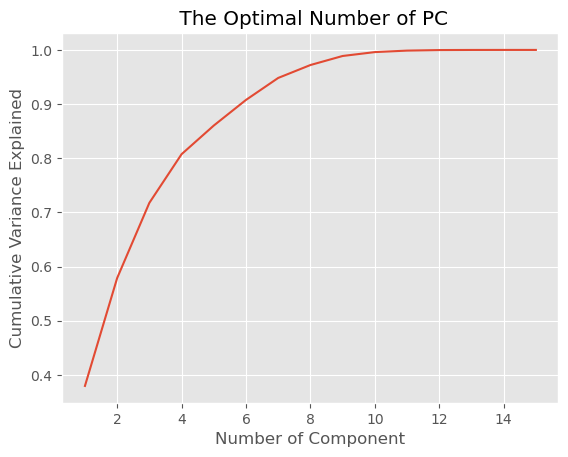

ALL PERIODS


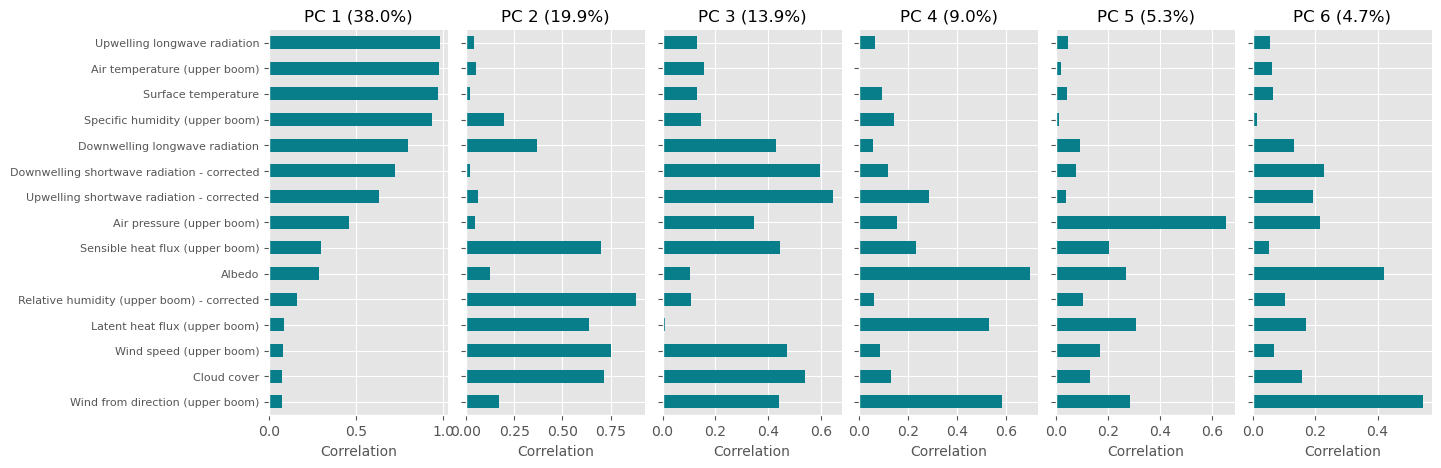

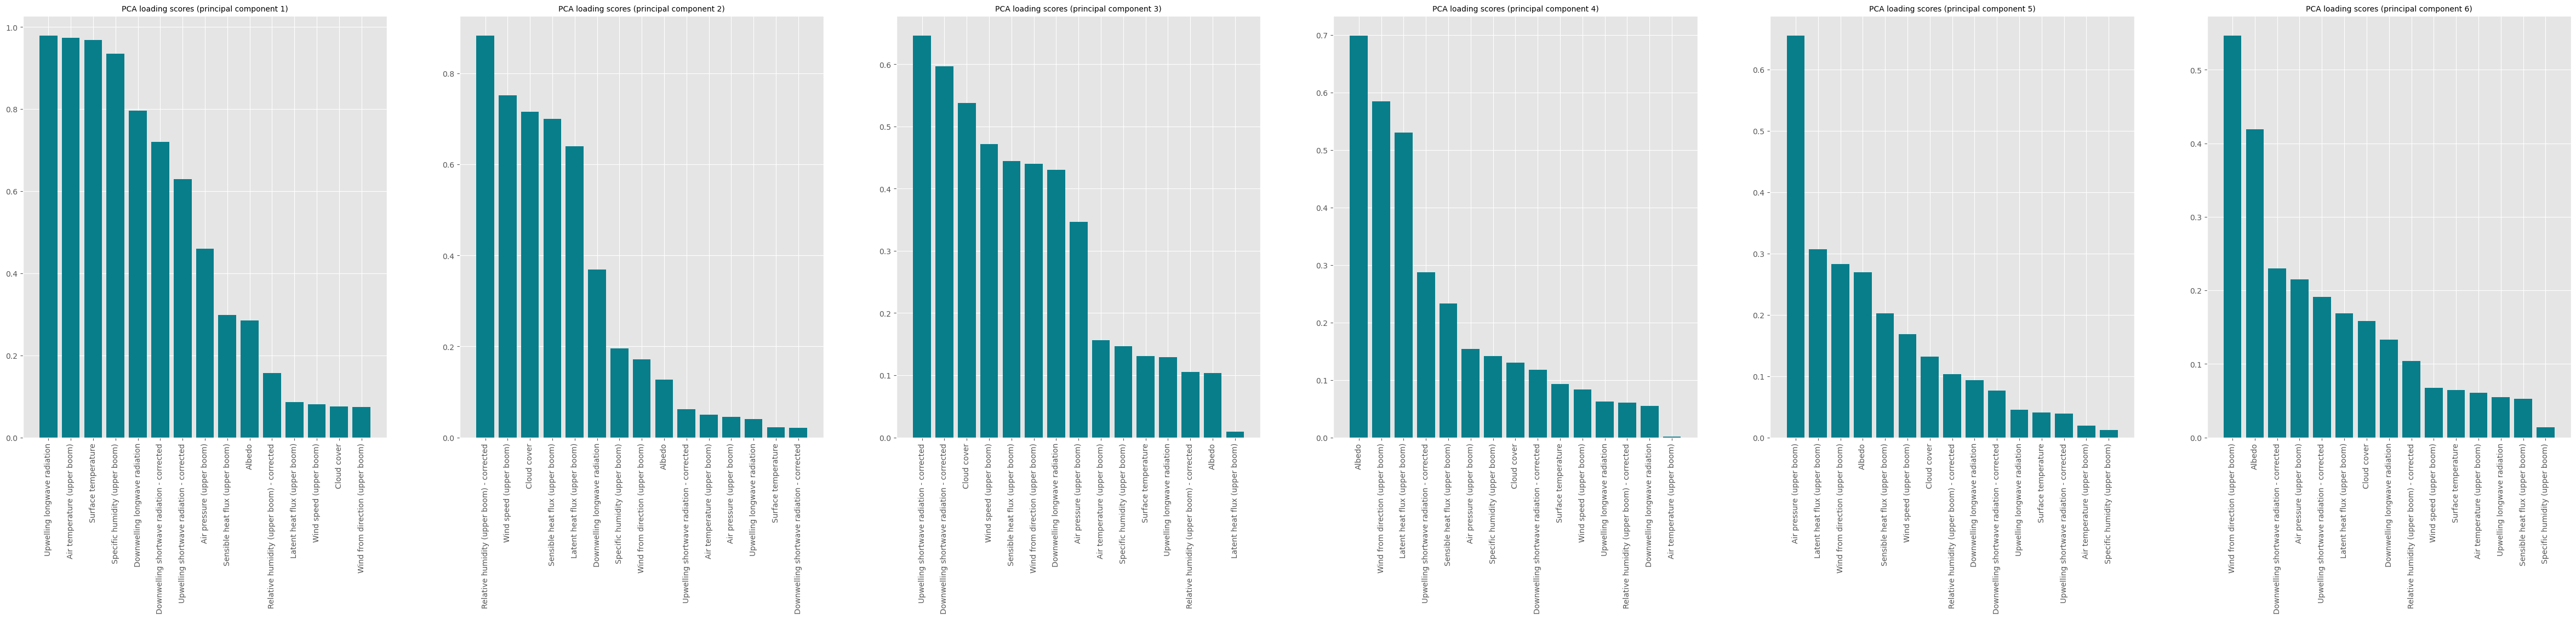

PCA  ABSOLUTE PRE
----------------------------------------------------------------------------------------


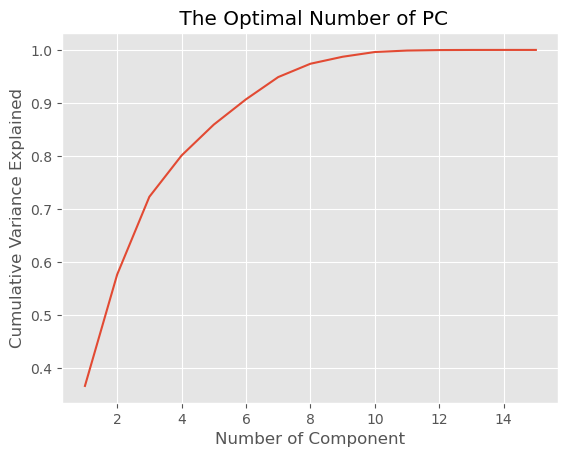

PC 1 (36.6%)  PC 2 (21.0%)  \
Air pressure (upper boom)                        0.430629     -0.322380   
Air temperature (upper boom)                     0.939138     -0.096837   
Relative humidity (upper boom) - corrected      -0.479338     -0.744735   
Specific humidity (upper boom)                   0.647554     -0.218631   
Wind speed (upper boom)                          0.515663      0.718579   
Wind from direction (upper boom)                 0.157776     -0.278577   
Downwelling shortwave radiation - corrected      0.519707     -0.349699   
Upwelling shortwave radiation - corrected        0.516436     -0.488821   
Downwelling longwave radiation                   0.626329     -0.378921   
Upwelling longwave radiation                     0.920042     -0.207286   
Surface temperature                              0.961657     -0.206655   
Latent heat flux (upper boom)                   -0.612151     -0.436161   
Sensible heat flux (upper boom)                  0.449968      0.737500   
Albedo                                          -0.046079     -0.391877   
Cloud cover                                     -0.249840     -0.527641   

                                             PC 3 (14.7%)  PC 4 (7.8%)  \
Air pressure (upper boom)                       -0.370964     0.469100   
Air temperature (upper boom)                     0.126558     0.111362   
Relative humidity (upper boom) - corrected       0.262750     0.222240   
Specific humidity (upper boom)                   0.133265     0.209829   
Wind speed (upper boom)                          0.272829    -0.066172   
Wind from direction (upper boom)                 0.607861    -0.460924   
Downwelling shortwave radiation - corrected     -0.539925    -0.158250   
Upwelling shortwave radiation - corrected       -0.613417    -0.280623   
Downwelling longwave radiation                   0.485813     0.071272   
Upwelling longwave radiation                     0.116417     0.068428   
Surface temperature                              0.114237     0.055521   
Latent heat flux (upper boom)                    0.047462     0.481276   
Sensible heat flux (upper boom)                  0.256304     0.216193   
Albedo                                          -0.056209    -0.442963   
Cloud cover                                      0.675504    -0.056058   

                                             PC 5 (5.8%)  PC 6 (4.8%)  
Air pressure (upper boom)                       0.558004     0.064921  
Air temperature (upper boom)                   -0.075027    -0.035296  
Relative humidity (upper boom) - corrected      0.051779     0.005693  
Specific humidity (upper boom)                 -0.055433    -0.034049  
Wind speed (upper boom)                         0.236564    -0.124209  
Wind from direction (upper boom)                0.477185     0.438053  
Downwelling shortwave radiation - corrected    -0.058327     0.092981  
Upwelling shortwave radiation - corrected      -0.002831     0.003875  
Downwelling longwave radiation                 -0.163313    -0.098242  
Upwelling longwave radiation                   -0.100043    -0.003372  
Surface temperature                            -0.095589    -0.001742  
Latent heat flux (upper boom)                   0.171260    -0.106747  
Sensible heat flux (upper boom)                 0.195225    -0.187191  
Albedo                                          0.311972    -0.634753  
Cloud cover                                    -0.172138    -0.122178

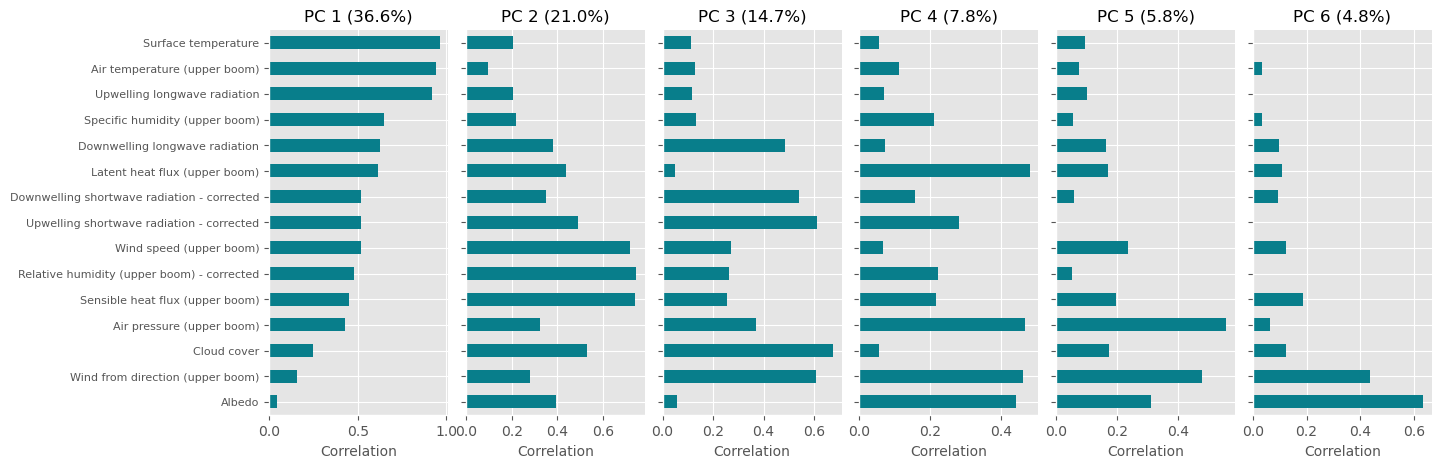

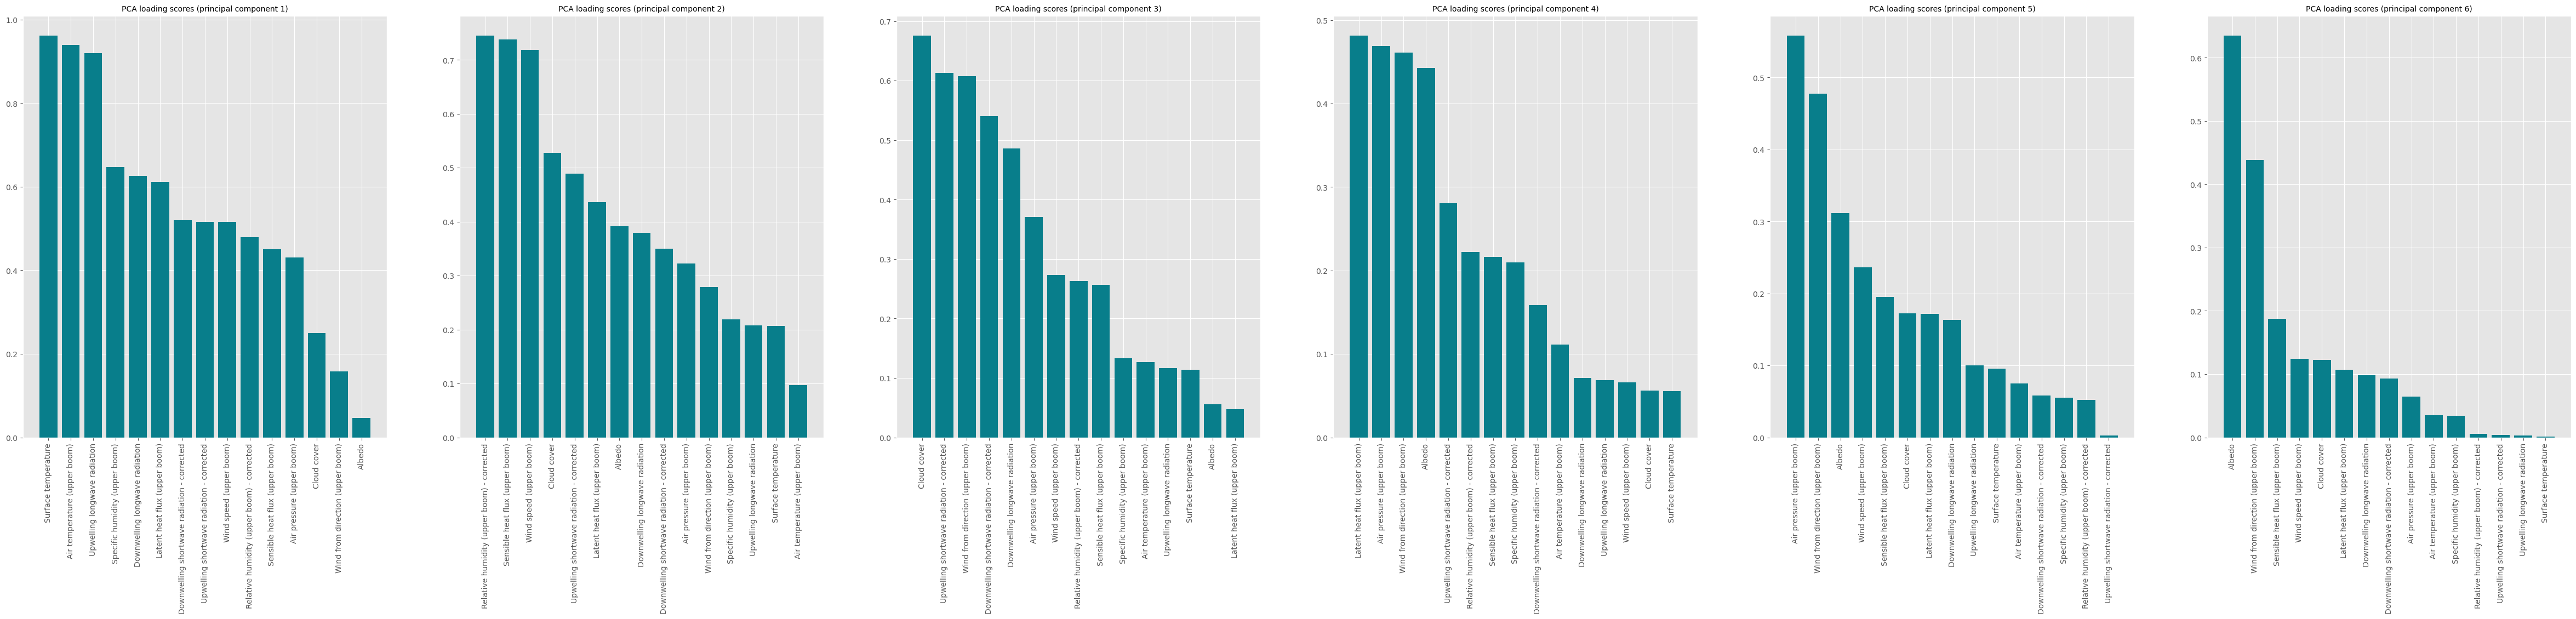

PCA  ABSOLUTE BEGINNING
----------------------------------------------------------------------------------------


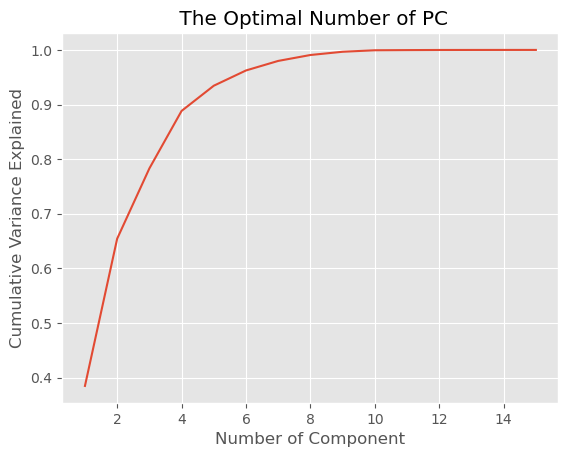

PC 1 (38.5%)  PC 2 (27.0%)  \
Air pressure (upper boom)                        0.098218     -0.080191   
Air temperature (upper boom)                     0.124195      0.150222   
Relative humidity (upper boom) - corrected      -0.734740     -0.013588   
Specific humidity (upper boom)                  -0.108775      0.240978   
Wind speed (upper boom)                          0.512355      0.284747   
Wind from direction (upper boom)                -0.194476      0.406228   
Downwelling shortwave radiation - corrected      0.327896     -0.400225   
Upwelling shortwave radiation - corrected        0.163294     -0.502623   
Downwelling longwave radiation                  -0.280445      0.452565   
Upwelling longwave radiation                     0.024471      0.084968   
Surface temperature                              0.009107      0.046351   
Latent heat flux (upper boom)                   -0.397427      0.288821   
Sensible heat flux (upper boom)                  0.949792      0.750471   
Albedo                                          -0.283883     -0.189125   
Cloud cover                                     -0.712821      0.526656   

                                             PC 3 (12.9%)  PC 4 (10.5%)  \
Air pressure (upper boom)                       -0.007963     -0.313447   
Air temperature (upper boom)                    -0.089450     -0.040708   
Relative humidity (upper boom) - corrected      -0.247502      0.277881   
Specific humidity (upper boom)                  -0.270099      0.054531   
Wind speed (upper boom)                          0.126391      0.129964   
Wind from direction (upper boom)                 0.399470      0.550097   
Downwelling shortwave radiation - corrected     -0.121990      0.172378   
Upwelling shortwave radiation - corrected        0.076519      0.240912   
Downwelling longwave radiation                   0.068218     -0.173014   
Upwelling longwave radiation                    -0.044265     -0.038470   
Surface temperature                             -0.034719     -0.025326   
Latent heat flux (upper boom)                   -0.596544      0.209650   
Sensible heat flux (upper boom)                 -0.081805      0.101020   
Albedo                                           0.365821      0.140355   
Cloud cover                                      0.272027     -0.238971   

                                             PC 5 (4.6%)  
Air pressure (upper boom)                       0.501201  
Air temperature (upper boom)                    0.022258  
Relative humidity (upper boom) - corrected     -0.004925  
Specific humidity (upper boom)                  0.014795  
Wind speed (upper boom)                        -0.059716  
Wind from direction (upper boom)                0.231894  
Downwelling shortwave radiation - corrected     0.086407  
Upwelling shortwave radiation - corrected       0.050620  
Downwelling longwave radiation                  0.011425  
Upwelling longwave radiation                    0.009222  
Surface temperature                             0.005852  
Latent heat flux (upper boom)                   0.078261  
Sensible heat flux (upper boom)                -0.012297  
Albedo                                         -0.048134  
Cloud cover                                    -0.024042

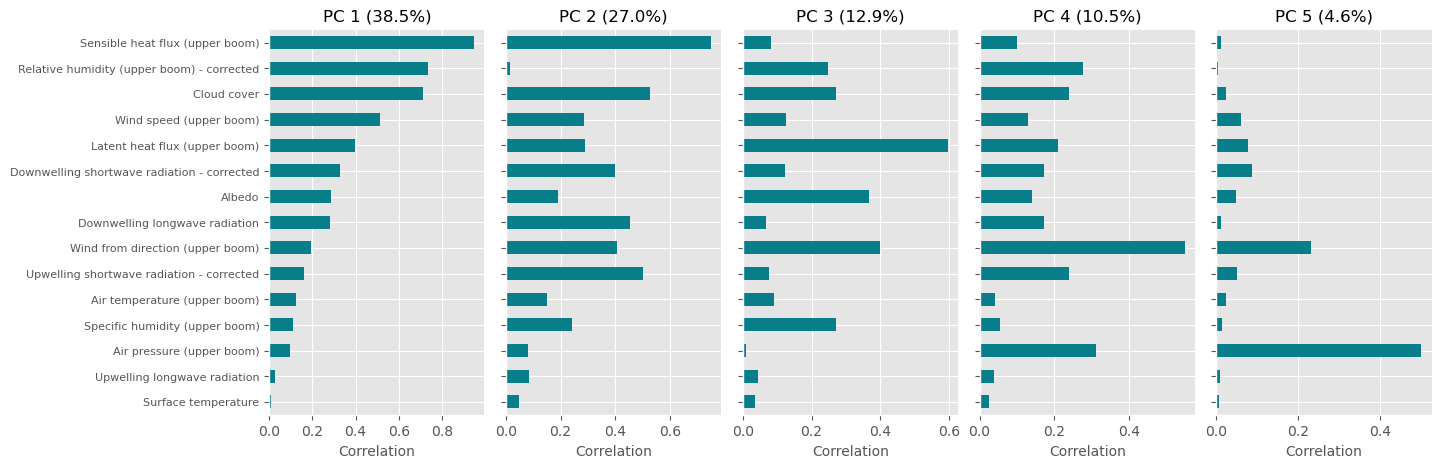

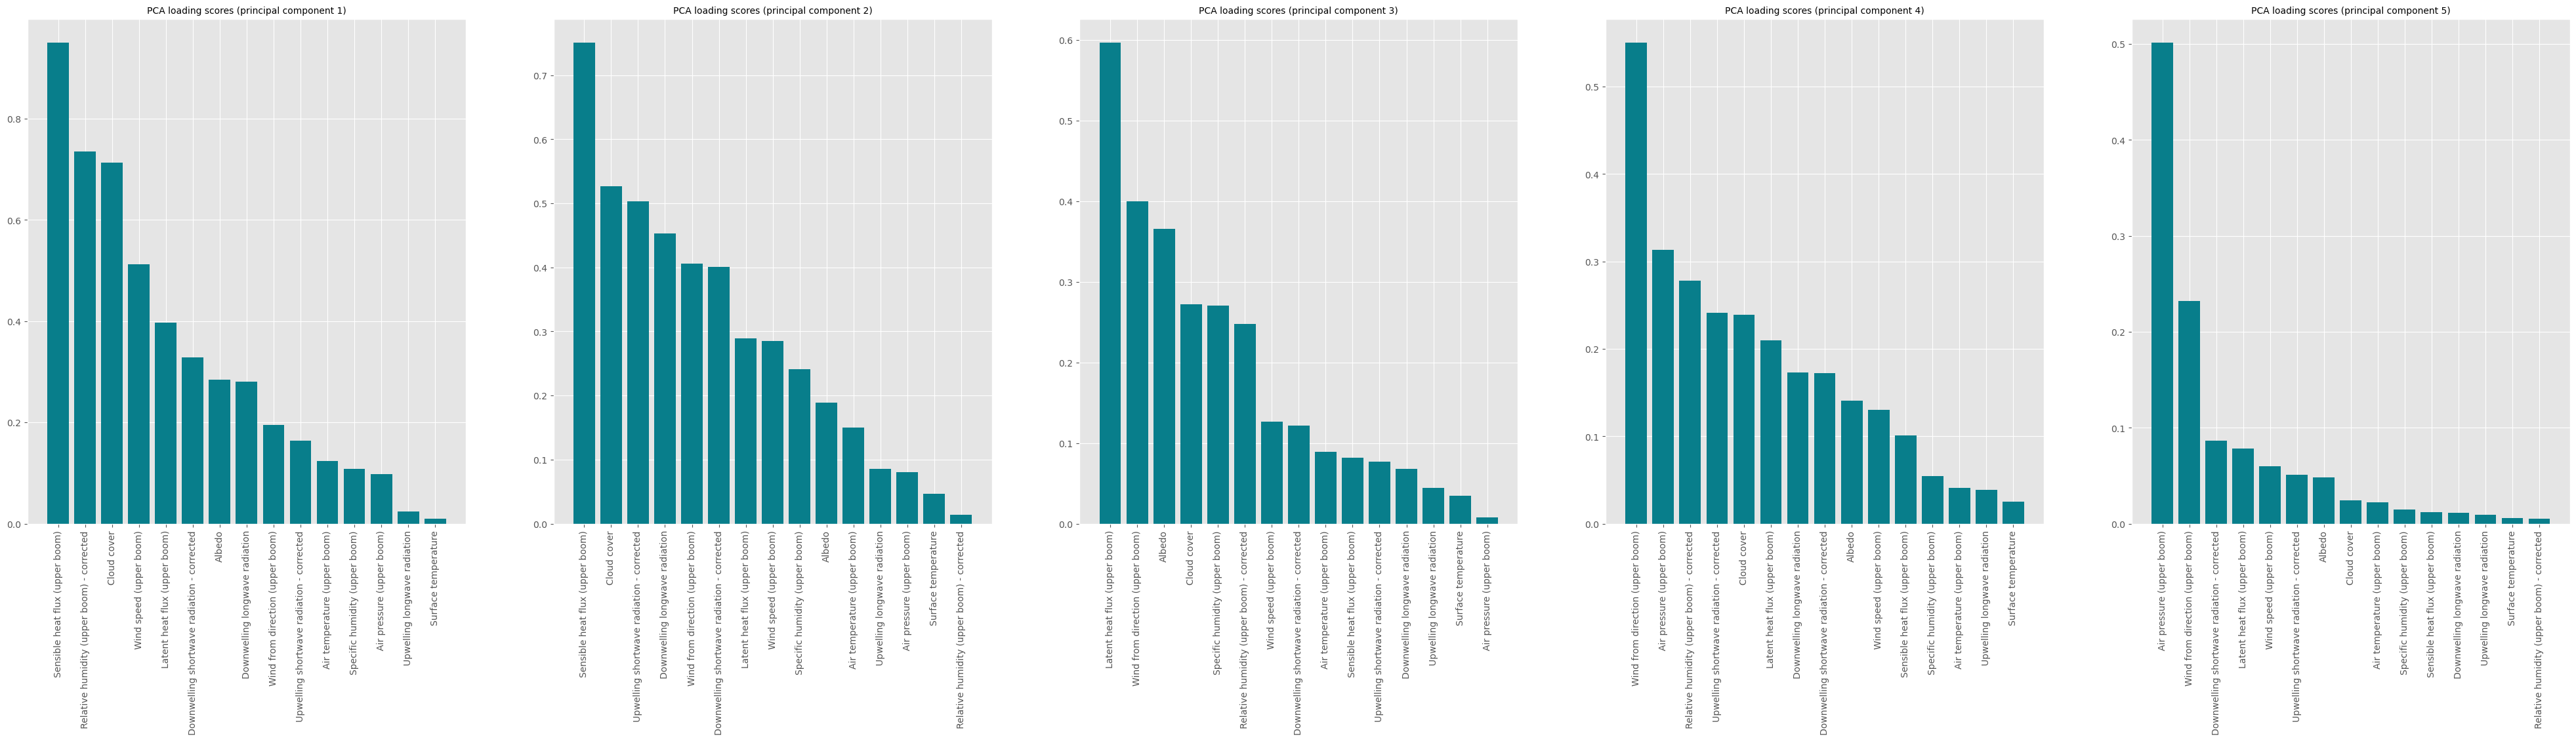

PCA  ABSOLUTE MIDDLE
----------------------------------------------------------------------------------------


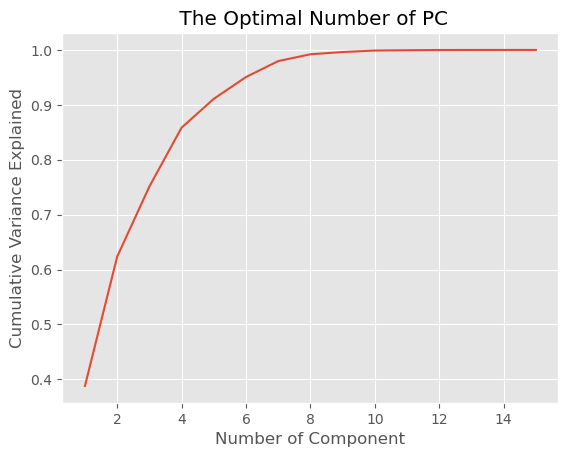

PC 1 (38.8%)  PC 2 (23.5%)  \
Air pressure (upper boom)                       -0.057430      0.129957   
Air temperature (upper boom)                    -0.000720      0.172250   
Relative humidity (upper boom) - corrected       0.624800     -0.247087   
Specific humidity (upper boom)                   0.291258      0.222789   
Wind speed (upper boom)                         -0.106078      0.440316   
Wind from direction (upper boom)                 0.325368     -0.133351   
Downwelling shortwave radiation - corrected     -0.546901      0.055470   
Upwelling shortwave radiation - corrected       -0.463804     -0.106968   
Downwelling longwave radiation                   0.507230      0.085257   
Upwelling longwave radiation                     0.027845      0.067730   
Surface temperature                              0.010056      0.026905   
Latent heat flux (upper boom)                    0.662302      0.516816   
Sensible heat flux (upper boom)                 -0.061586      0.861825   
Albedo                                           0.075482     -0.394053   
Cloud cover                                      0.892592     -0.153453   

                                             PC 3 (12.8%)  PC 4 (10.7%)  \
Air pressure (upper boom)                       -0.165538      0.113888   
Air temperature (upper boom)                    -0.010123     -0.030447   
Relative humidity (upper boom) - corrected      -0.277870      0.289565   
Specific humidity (upper boom)                  -0.148124      0.083085   
Wind speed (upper boom)                          0.239612     -0.011488   
Wind from direction (upper boom)                 0.633726      0.484472   
Downwelling shortwave radiation - corrected     -0.186638      0.271532   
Upwelling shortwave radiation - corrected       -0.091909      0.291625   
Downwelling longwave radiation                   0.035837     -0.170667   
Upwelling longwave radiation                    -0.008089     -0.017508   
Surface temperature                             -0.012390     -0.008828   
Latent heat flux (upper boom)                   -0.314480      0.342452   
Sensible heat flux (upper boom)                  0.267422     -0.029716   
Albedo                                           0.230261      0.113148   
Cloud cover                                      0.079886     -0.250649   

                                             PC 5 (5.3%)  
Air pressure (upper boom)                      -0.459084  
Air temperature (upper boom)                   -0.042937  
Relative humidity (upper boom) - corrected      0.100829  
Specific humidity (upper boom)                 -0.001218  
Wind speed (upper boom)                         0.073122  
Wind from direction (upper boom)               -0.122591  
Downwelling shortwave radiation - corrected    -0.120595  
Upwelling shortwave radiation - corrected      -0.049953  
Downwelling longwave radiation                 -0.141793  
Upwelling longwave radiation                   -0.041891  
Surface temperature                            -0.022481  
Latent heat flux (upper boom)                   0.130730  
Sensible heat flux (upper boom)                 0.031499  
Albedo                                          0.153567  
Cloud cover                                    -0.171900

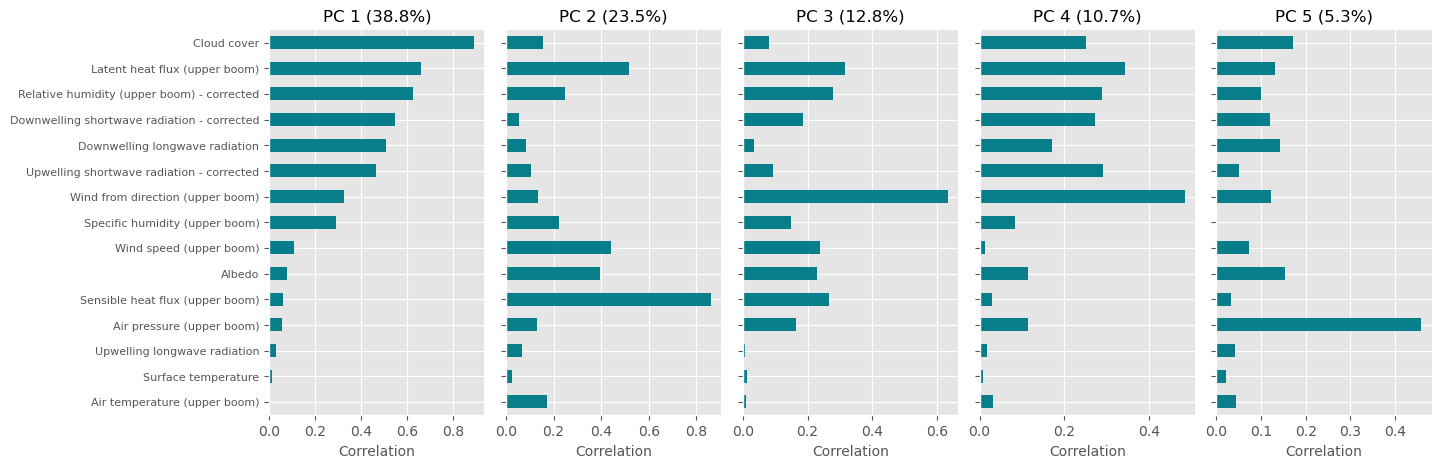

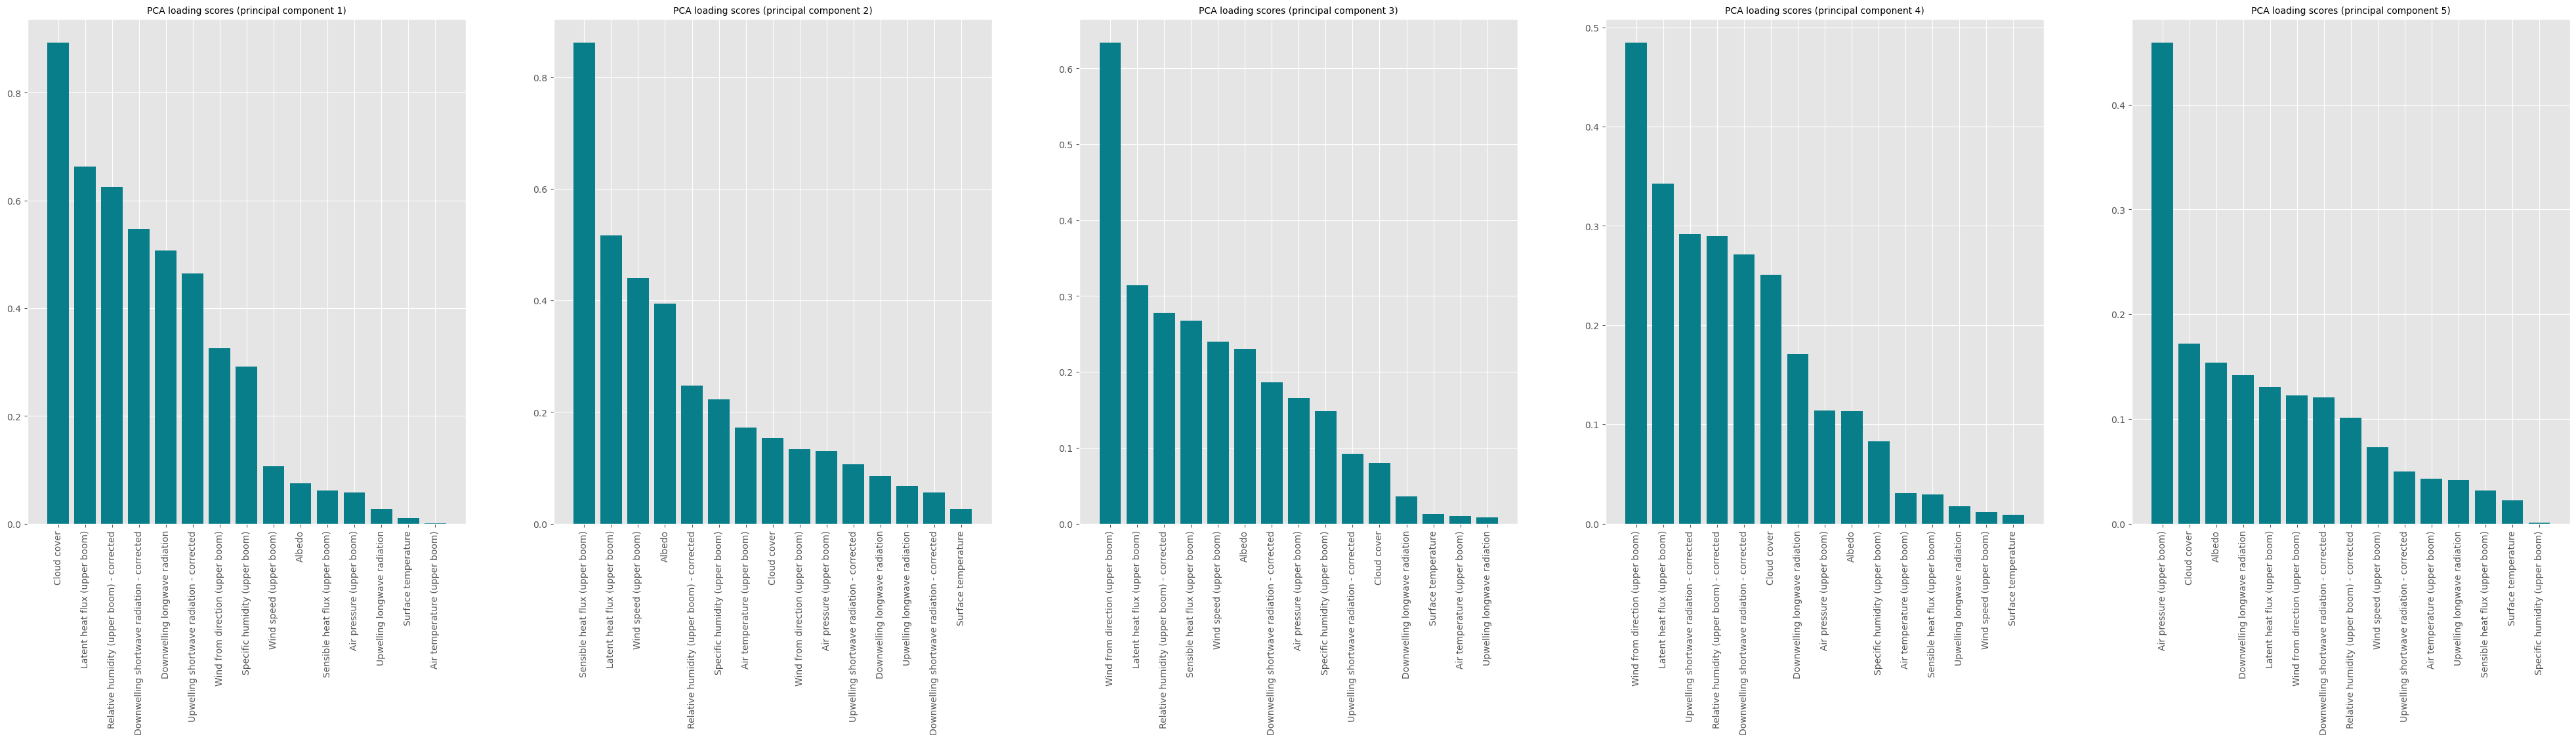

PCA  ABSOLUTE END
----------------------------------------------------------------------------------------


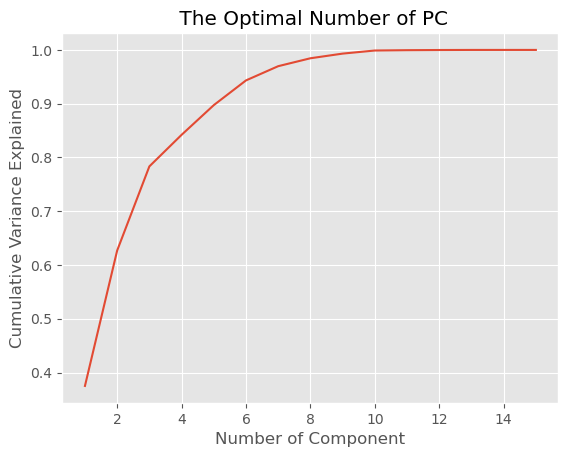

PC 1 (37.5%)  PC 2 (25.2%)  \
Air pressure (upper boom)                        0.027378     -0.104626   
Air temperature (upper boom)                    -0.056186      0.339763   
Relative humidity (upper boom) - corrected      -0.836259     -0.174027   
Specific humidity (upper boom)                  -0.359311      0.463130   
Wind speed (upper boom)                          0.373124      0.549853   
Wind from direction (upper boom)                -0.557004      0.002405   
Downwelling shortwave radiation - corrected      0.230419     -0.107049   
Upwelling shortwave radiation - corrected        0.235125     -0.262188   
Downwelling longwave radiation                  -0.603449      0.394997   
Upwelling longwave radiation                    -0.133701      0.301300   
Surface temperature                             -0.104955      0.245459   
Latent heat flux (upper boom)                   -0.706719      0.042243   
Sensible heat flux (upper boom)                  0.330847      0.793891   
Albedo                                          -0.159496     -0.732670   
Cloud cover                                     -0.963011      0.124539   

                                             PC 3 (15.6%)  PC 4 (5.9%)  \
Air pressure (upper boom)                       -0.287460     0.349460   
Air temperature (upper boom)                    -0.011408    -0.073503   
Relative humidity (upper boom) - corrected      -0.178622     0.055061   
Specific humidity (upper boom)                  -0.110481    -0.050193   
Wind speed (upper boom)                          0.365796     0.202449   
Wind from direction (upper boom)                 0.693162     0.136953   
Downwelling shortwave radiation - corrected     -0.103235    -0.005162   
Upwelling shortwave radiation - corrected       -0.022406     0.049726   
Downwelling longwave radiation                   0.086422    -0.130400   
Upwelling longwave radiation                    -0.007092    -0.113678   
Surface temperature                             -0.000147    -0.120639   
Latent heat flux (upper boom)                   -0.476563     0.399360   
Sensible heat flux (upper boom)                  0.208354     0.288861   
Albedo                                           0.579343     0.165500   
Cloud cover                                      0.171669    -0.115334   

                                             PC 5 (5.5%)  PC 6 (4.6%)  
Air pressure (upper boom)                       0.342620     0.340181  
Air temperature (upper boom)                    0.114512     0.082306  
Relative humidity (upper boom) - corrected     -0.010744    -0.027761  
Specific humidity (upper boom)                  0.118962     0.077060  
Wind speed (upper boom)                        -0.119242     0.025867  
Wind from direction (upper boom)                0.379624    -0.296387  
Downwelling shortwave radiation - corrected     0.172978     0.013211  
Upwelling shortwave radiation - corrected       0.149979     0.066873  
Downwelling longwave radiation                  0.004770     0.175558  
Upwelling longwave radiation                    0.140175     0.089493  
Surface temperature                             0.140539     0.083208  
Latent heat flux (upper boom)                  -0.144079    -0.181828  
Sensible heat flux (upper boom)                -0.139690     0.053175  
Albedo                                         -0.166891     0.273853  
Cloud cover                                    -0.172148     0.176011

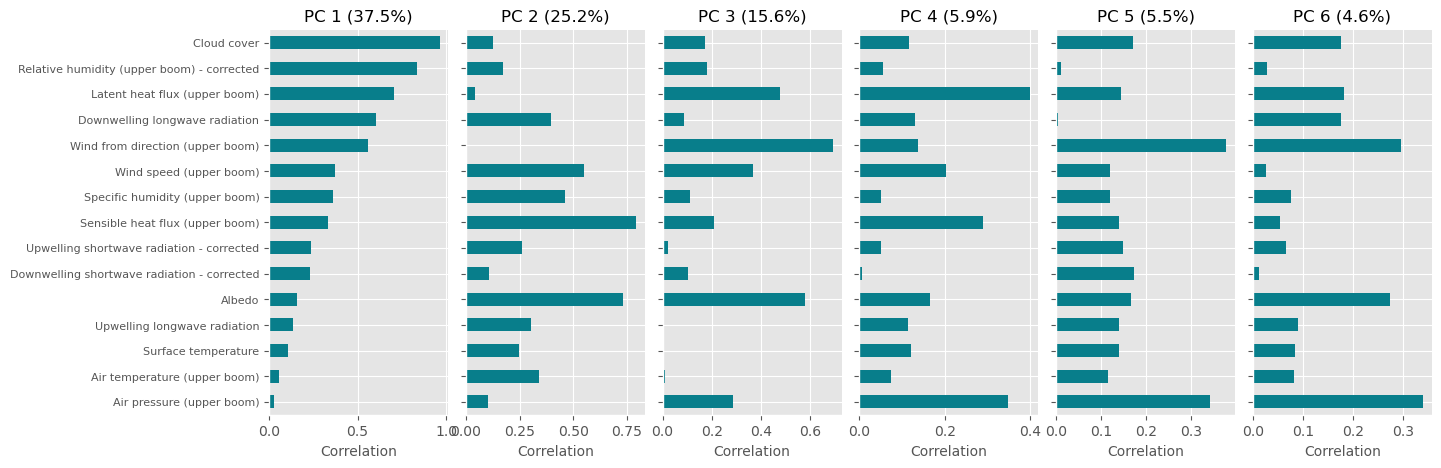

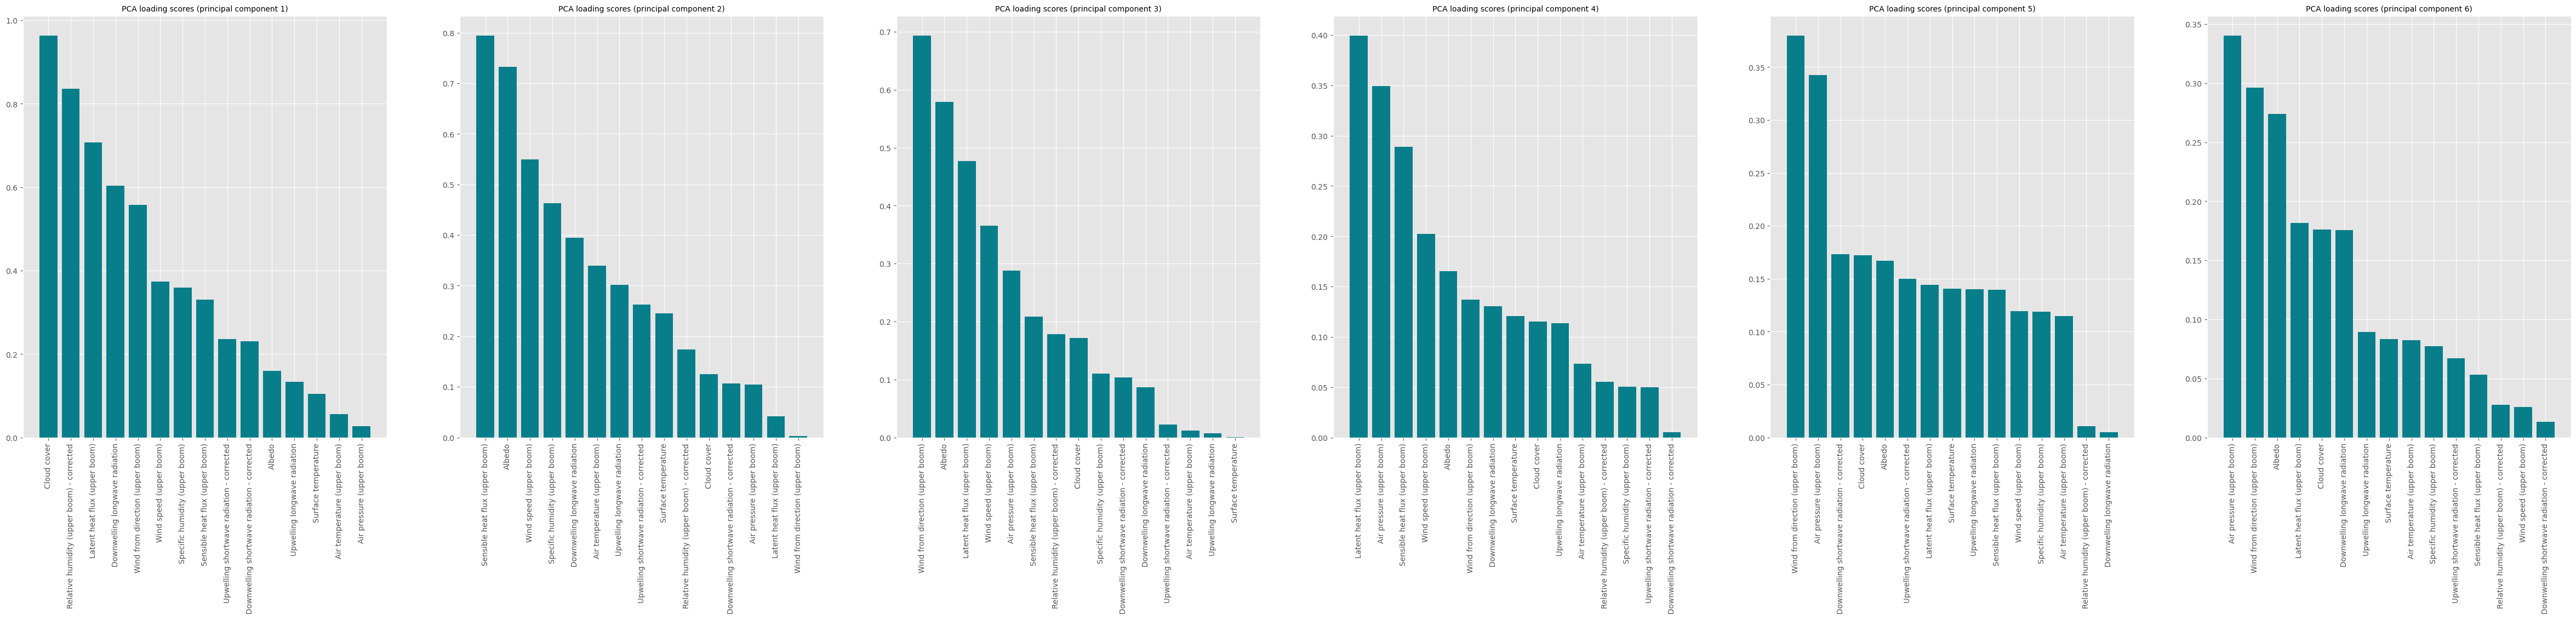

In [359]:
# Apply PCA
from sklearn.decomposition import PCA

print('pca all periods')
pca = PCA()
X_train_imp = pca.fit_transform(X_absolute_train[num_cols])
X_test_imp = pca.transform(X_absolute_test[num_cols])

# visualizing the amount of variance data explained for each principle component
cumulative_variance_explained = np.cumsum(pca.explained_variance_ratio_)
x_values = list(range(1, len(cumulative_variance_explained)+1))

#plot the line graph explaining variance of feature variables through the components
plt.plot(x_values, cumulative_variance_explained)
plt.xlabel('Number of Component')
plt.ylabel('Cumulative Variance Explained')
plt.title(' The Optimal Number of PC')
plt.show()

measures = ['delta', 'absolute']
for measure in measures:
    print('TESTING',measure.upper())
    print('-----------------------------------------------------------------------------------------')
    X_train = eval(f'X_{measure}_train')
    X_test = eval(f'X_{measure}_test')
    y_train = eval(f'y_{measure}_train')
    y_test = eval(f'y_{measure}_test')

    pca = PCA()
    X_train_imp = pca.fit_transform(X_absolute_train[num_cols])
    cumulative_variance_explained = np.cumsum(pca.explained_variance_ratio_)
    x_values = list(range(1, len(cumulative_variance_explained)+1))
    plot_cum_variance(x_values, cumulative_variance_explained)
    optimal_component = np.argmax(cumulative_variance_explained >=0.9) + 1
    pca = PCA(n_components = optimal_component)
    X_train_pca = pca.fit_transform(X_absolute_train[num_cols])
    labels = {
    str(i):f"PC {i+1} ({var:.1f}%)"
    for i, var in enumerate(pca.explained_variance_ratio_*100)
    }

    labels_vals = list(labels.values())
    loadings = pd.DataFrame(
    data=pca.components_.T * np.sqrt(pca.explained_variance_), 
    columns= labels_vals,
    index=  X_train[num_cols].columns
    )
    print('ALL PERIODS')
    plot_pca_vert(labels_vals, loadings, absolute=True)
    plot_pca_loadings(labels_vals, loadings)


    
    for period in periods:
        indices = eval(f'indices_{period}')
        print('PCA ', measure.upper(), period.upper())
        print('----------------------------------------------------------------------------------------')

        # Find common indexes
        X_Train_valid_indices = indices.intersection(X_train.index)
        y_Train_valid_indices = indices.intersection(y_train.index)
        X_Test_valid_indices = indices.intersection(X_test.index)
        y_Test_valid_indices = indices.intersection(y_test.index)

            # filter out by indeces
        X_train_category = X_delta_train.loc[X_Train_valid_indices]
        y_train_category = y_delta_train.loc[y_Train_valid_indices]
        X_test_category = X_delta_test.loc[X_Test_valid_indices]
        y_test_category = y_delta_test.loc[y_Test_valid_indices]

        pca = PCA()
        
        X_train_imp = pca.fit_transform(X_train_category[num_cols])
        x_test_imp = pca.transform(X_test_category[num_cols])

        cumulative_variance_explained = np.cumsum(pca.explained_variance_ratio_)
        x_values = list(range(1, len(cumulative_variance_explained)+1))

        #Visualizing arm-bar plot 
        plot_cum_variance(x_values, cumulative_variance_explained)

        #Identify the optimal number of principal components 
        optimal_component = np.argmax(cumulative_variance_explained >=0.9) + 1

        #Transform data with the optimal number of components
        pca = PCA(n_components = optimal_component)

        X_train_pca = pca.fit_transform(X_train_category[num_cols])
        X_test_pca = pca.transform(X_test_category[num_cols])
        
        labels = {
        str(i):f"PC {i+1} ({var:.1f}%)"
        for i, var in enumerate(pca.explained_variance_ratio_*100)
        }
    
        labels_vals = list(labels.values())
        loadings = pd.DataFrame(
        data=pca.components_.T * np.sqrt(pca.explained_variance_), 
        columns= labels_vals,
        index=  X_train[num_cols].columns
        )
        display(loadings)

        

        plot_pca_vert(labels_vals, loadings, absolute=True)
        plot_pca_loadings(labels_vals, loadings)



<class 'numpy.ndarray'>


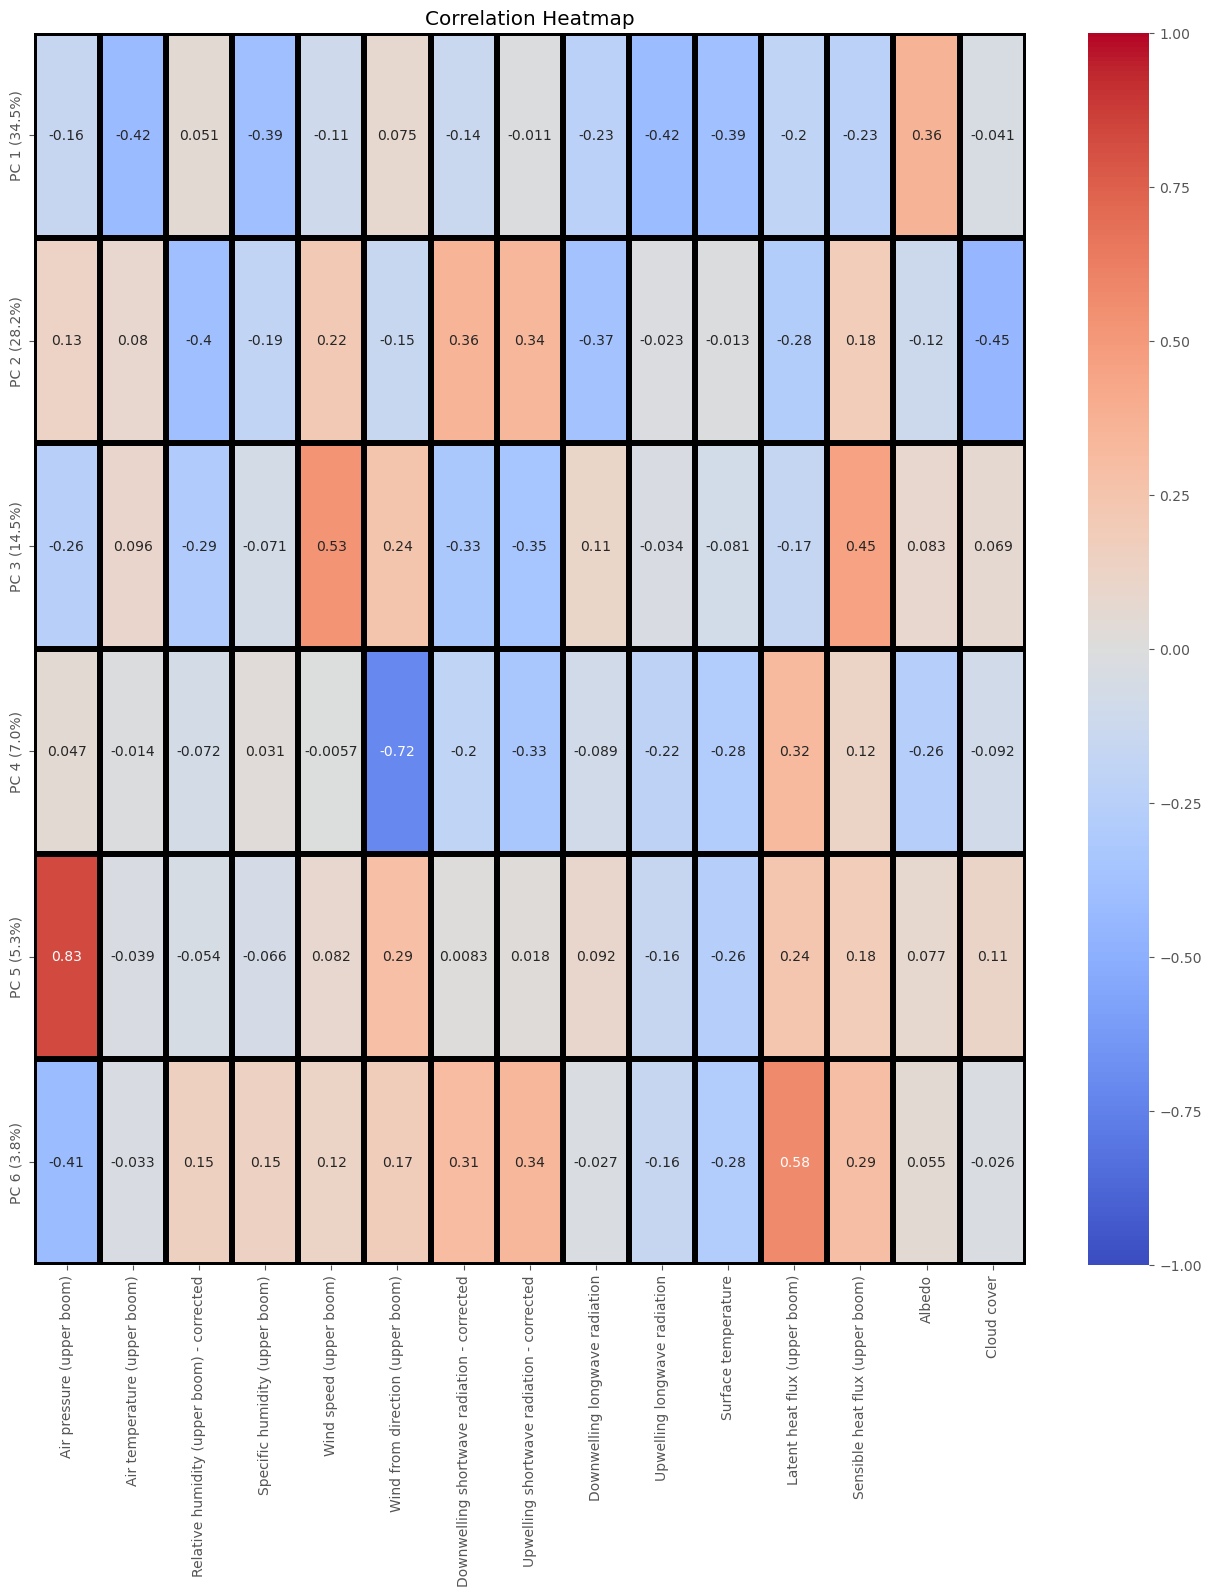

In [297]:
#Identify the optimal number of principal components 
optimal_component = np.argmax(cumulative_variance_explained >=0.9) + 1

#Transform data with the optimal number of components
pca = PCA(n_components = optimal_component)

X_train_pca = pca.fit_transform(X_train[num_cols])
X_test_pca = pca.transform(X_test[num_cols])

labels = {
    str(i):f"PC {i+1} ({var:.1f}%)"
    for i, var in enumerate(pca.explained_variance_ratio_*100)
    }
print(type(pca.explained_variance_ratio_))


def pca_relationship(pca_model):
    color_map = {
    'beginning': 'green',
    'middle': 'yellow',
    'end': 'red'
    }
    fig = px.scatter_matrix(
        pca_model,
        labels=labels,
        dimensions=range(4),
        color=X_train['Melting Season'],
        color_discrete_map=color_map)
    
    fig.update_traces(diagonal_visible=False)
    fig.show()

def pca_heatmap(dataframe):
    #plot a heatmap to visualise how the feature variables contribute to PC
    # Heatmap
    plt.figure(figsize=(16, 16))

    heatmap = sns.heatmap(dataframe, annot = True, vmin=-1, vmax=1, center= 0, cmap= 'coolwarm', linewidths=3, linecolor='black')

    heatmap.set_title('Correlation Heatmap')
    plt.show()

pca_df = pd.DataFrame(pca.components_,
                columns = num_cols,
                index =labels.values(),
                )
pca_heatmap(pca_df)
pca_relationship(X_train_pca)




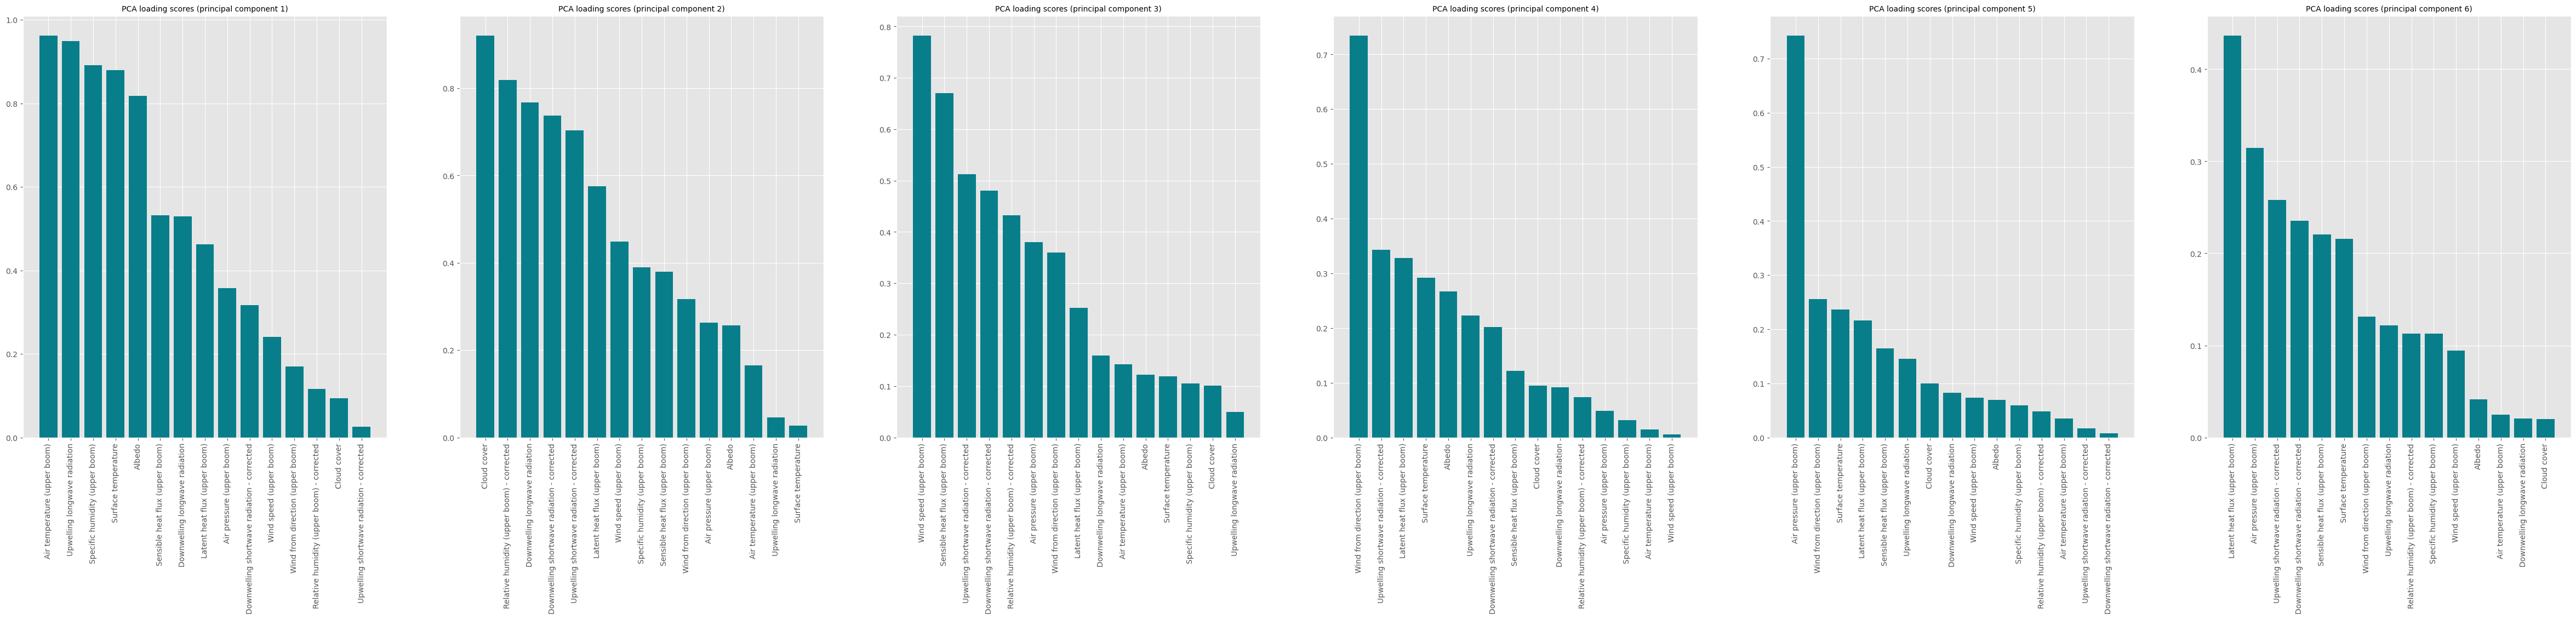

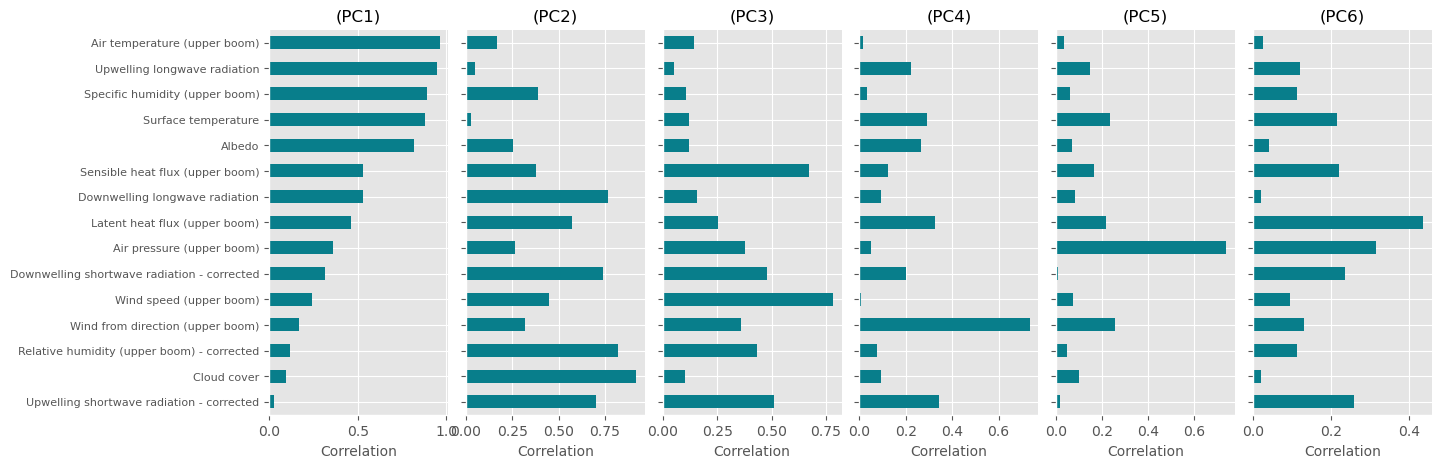

In [298]:
labels_vals = list(labels.values())
loadings = pd.DataFrame(
    data=pca.components_.T * np.sqrt(pca.explained_variance_), 
    columns= labels_vals,
    index=  X_train[num_cols].columns
)

def plot_pca_loadings(labels_vals, loadings):
    fig, axes = plt.subplots(1, len(labels_vals), figsize=(len(labels_vals)*10, 10))

    for i, label in enumerate(labels_vals):
        pc_loadings = loadings.abs().sort_values(by=label, ascending=False)[[label]]
        pc_loadings = pc_loadings.reset_index()
        pc_loadings.columns = ['Attribute', 'CorrelationWithPC{}'.format(i+1)]
        axes[i].bar(x=pc_loadings['Attribute'], height=pc_loadings['CorrelationWithPC{}'.format(i+1)], color='#087E8B')
        axes[i].set_title('PCA loading scores (principal component {})'.format(i+1), size=10)
        axes[i].tick_params(axis='x', rotation=90)

    plt.show()

plot_pca_loadings(labels_vals, loadings)


def plot_pca_stacked(labels_vals, loadings):
    fig, axs = plt.subplots(nrows=len(loadings.columns), sharey=True, figsize=(8, 10))

    # Loop over each column in the loadings dataframe and create a bar chart for each feature
    for i, col in enumerate(loadings.columns):
        axs[i].bar(x=loadings.index, height=loadings[col].abs(), color='#087E8B')
        axs[i].set_title(col)
        axs[i].tick_params(labelbottom=False, bottom=False)  # Hide x-axis labels and ticks for all subplots except the bottom one
        axs[i].spines['right'].set_visible(False)  # Hide right spines for all subplots
        axs[i].spines['top'].set_visible(False)  # Hide top spines for all subplots
        if i == len(loadings.columns) - 1:
            axs[i].tick_params(labelbottom=True, bottom=True, labelrotation=90)

    # Set y-axis label and adjust subplots layout
    fig.text(0, 0.5, 'Contribution to PCA', va='center', rotation='vertical')
    fig.tight_layout(pad=1.5)
    plt.show()

#plot_pca_stacked(labels_vals, loadings)

def plot_pca_vert(labels_vals,loadings, absolute=False):
    plt.style.use('ggplot')
    fig, axes = plt.subplots(nrows=1, ncols=len(loadings.columns), figsize=(15,5), sharey=True)
    if absolute:
        loadings = loadings.abs()
    loadings = loadings.sort_values(by=loadings.columns[0],ascending=True)
    for i, col in enumerate(loadings.columns):

        loadings[col].plot(kind='barh', ax=axes[i], color='#087E8B')
            
        axes[i].set_title(f'(PC{i+1})', size=12)
        axes[i].set_ylabel('')
        axes[i].set_xlabel('Correlation', size=10)
        axes[i].tick_params(axis='y', rotation=0, labelsize=8)
        axes[i].set_yticks(np.arange(len(loadings.index)))
        axes[i].set_yticklabels(loadings.index, fontsize=8)
        axes[i].spines['right'].set_visible(False)
        axes[i].spines['top'].set_visible(False)

    plt.subplots_adjust(wspace=0.1)
    plt.show()

plot_pca_vert(labels_vals, loadings, absolute=True)

-------------------------------- Without Imputation ---------------------------------------------------

In [299]:
#  We can follow this paper: https://www.sciencedirect.com/science/article/pii/S1574954121000261#:~:text=The%20standard%20algorithm%20of%20PCA%20is%20modified%20to%20accommodate%20incomplete%20data.&text=The%20method%20produces%20ordination%20scores%20for%20variables%20and%20observations%20simultaneously.&text=Information%20is%20maximally%20exhausted%2C%20while%20data%20imputation%20is%20not%20required.
# Or: https://github.com/allentran/pca-magic

import os

import numpy as np
from scipy.linalg import orth

class PPCA():

    def __init__(self):

        self.raw = None   # original data
        self.data = None  # standardized data
        self.C = None     # principal component matrix
        self.means = None # mean of data
        self.stds = None  # standard deviation of data
        self.eig_vals = None # eigenvalues of the covariance matrix

    def _standardize(self, X):
        """
        Internal function to standardize input data.

        Args:
            X (array): Input data to be standardized.

        Returns:
            array: Standardized data.
        """

        if self.means is None or self.stds is None:
            raise RuntimeError("Fit model first")

        return (X - self.means) / self.stds

    def fit(self, data, d=None, tol=1e-4, min_obs=10, verbose=False):
        """
        Fit the PPCA model to the input data.

        Args:
            data (array): Input data to fit the model.
            d (int, optional): Number of principal components to keep. Defaults to None, which is the same as the number of dimensions of the data.
            tol (float, optional): Tolerance for convergence. Defaults to 1e-4.
            min_obs (int, optional): Minimum number of observations required for a variable to be included in the model. Defaults to 10.
            verbose (bool, optional): Print the difference value for each iteration. Defaults to False.

        Raises:
            RuntimeError: If the model is not fit before calling _standardize function.

        Returns:
            None
        """

        self.raw = data
        self.raw[np.isinf(self.raw)] = np.max(self.raw[np.isfinite(self.raw)])

        valid_series = np.sum(~np.isnan(self.raw), axis=0) >= min_obs

        data = self.raw[:, valid_series].copy()
        N = data.shape[0]
        D = data.shape[1]

        self.means = np.nanmean(data, axis=0)
        self.stds = np.nanstd(data, axis=0)

        data = self._standardize(data)
        observed = ~np.isnan(data)
        missing = np.sum(~observed)
        data[~observed] = 0

        # initial

        if d is None:
            d = data.shape[1]
        
        if self.C is None:
            C = np.random.randn(D, d)
        else:
            C = self.C
        CC = np.dot(C.T, C)
        X = np.dot(np.dot(data, C), np.linalg.inv(CC))
        recon = np.dot(X, C.T)
        recon[~observed] = 0
        ss = np.sum((recon - data)**2)/(N*D - missing)

        v0 = np.inf
        counter = 0

        while True:

            Sx = np.linalg.inv(np.eye(d) + CC/ss)

            # e-step
            ss0 = ss
            if missing > 0:
                proj = np.dot(X, C.T)
                data[~observed] = proj[~observed]
            X = np.dot(np.dot(data, C), Sx) / ss

            # m-step
            XX = np.dot(X.T, X)
            C = np.dot(np.dot(data.T, X), np.linalg.pinv(XX + N*Sx))
            CC = np.dot(C.T, C)
            recon = np.dot(X, C.T)
            recon[~observed] = 0
            ss = (np.sum((recon-data)**2) + N*np.sum(CC*Sx) + missing*ss0)/(N*D)

            # calc diff for convergence
            det = np.log(np.linalg.det(Sx))
            if np.isinf(det):
                det = abs(np.linalg.slogdet(Sx)[1])
            v1 = N*(D*np.log(ss) + np.trace(Sx) - det) \
                + np.trace(XX) - missing*np.log(ss0)
            diff = abs(v1/v0 - 1)
            if verbose:
                print(diff)
            if (diff < tol) and (counter > 5):
                break

            counter += 1
            v0 = v1


        C = orth(C)
        vals, vecs = np.linalg.eig(np.cov(np.dot(data, C).T))
        order = np.flipud(np.argsort(vals))
        vecs = vecs[:, order]
        vals = vals[order]

        C = np.dot(C, vecs)

        # attach objects to class
        self.C = C
        self.data = data
        self.eig_vals = vals
        self._calc_var()

    def transform(self, data=None):

        if self.C is None:
            raise RuntimeError('Fit the data model first.')
        if data is None:
            return np.dot(self.data, self.C)
        return np.dot(data, self.C)

    def _calc_var(self):

        if self.data is None:
            raise RuntimeError('Fit the data model first.')

        data = self.data.T

        # variance calc
        var = np.nanvar(data, axis=1)
        total_var = var.sum()
        self.var_exp = self.eig_vals.cumsum() / total_var

    def save(self, fpath):

        np.save(fpath, self.C)
        
    def load(self, fpath):

        assert os.path.isfile(fpath)

        self.C = np.load(fpath)

['Air pressure (upper boom)', 'Air temperature (upper boom)', 'Relative humidity (upper boom) - corrected', 'Specific humidity (upper boom)', 'Wind speed (upper boom)', 'Wind from direction (upper boom)', 'Downwelling shortwave radiation - corrected', 'Upwelling shortwave radiation - corrected', 'Downwelling longwave radiation', 'Upwelling longwave radiation', 'Surface temperature', 'Latent heat flux (upper boom)', 'Sensible heat flux (upper boom)', 'Albedo', 'Cloud cover']


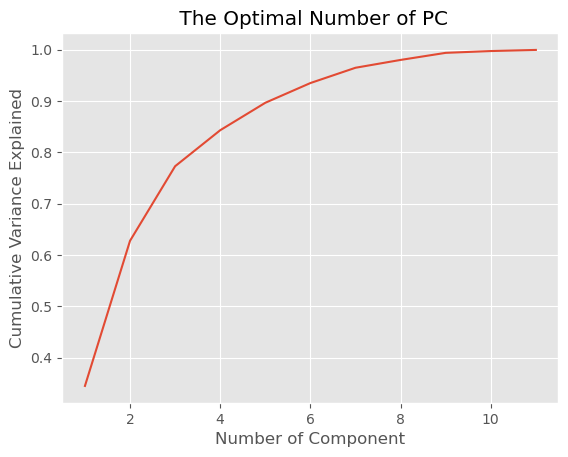

In [301]:
pp_X_train, pp_X_test,pp_y_train, pp_y_test = train_test_split(X,y,
                                   test_size=0.2, 
                                   random_state=2023,
                                   shuffle=False)

# This bit to convert all numerical values into the same scale 
num_cols = X.select_dtypes(include=['int64','float64']).columns.to_list()

scaler = MinMaxScaler()
scaler = StandardScaler()

pp_X_train[num_cols] = scaler.fit_transform(pp_X_train[num_cols])
pp_X_test[num_cols] = scaler.fit_transform(pp_X_test[num_cols])

ppca = PPCA()

ppca.fit(data = pp_X_train[num_cols].to_numpy(), d=30)

# visualizing the amount of variance data explained for each principle component
cumulative_variance_explained = ppca.var_exp
x_values = list(range(1, len(cumulative_variance_explained)+1))

#plot the line graph explaining variance of feature variables through the components
plt.plot(x_values, cumulative_variance_explained)
plt.xlabel('Number of Component')
plt.ylabel('Cumulative Variance Explained')
plt.title(' The Optimal Number of PC')
plt.show()


[0.34521785 0.62791141 0.77309524 0.84313077 0.89655808 0.93479221]
[0.3452178502356563, 0.2826935609490995, 0.14518383244534705, 0.07003552504982036, 0.05342731063348283, 0.03823413219790095]
{'0': 'PC 1 (34.5%)', '1': 'PC 2 (28.3%)', '2': 'PC 3 (14.5%)', '3': 'PC 4 (7.0%)', '4': 'PC 5 (5.3%)', '5': 'PC 6 (3.8%)'}


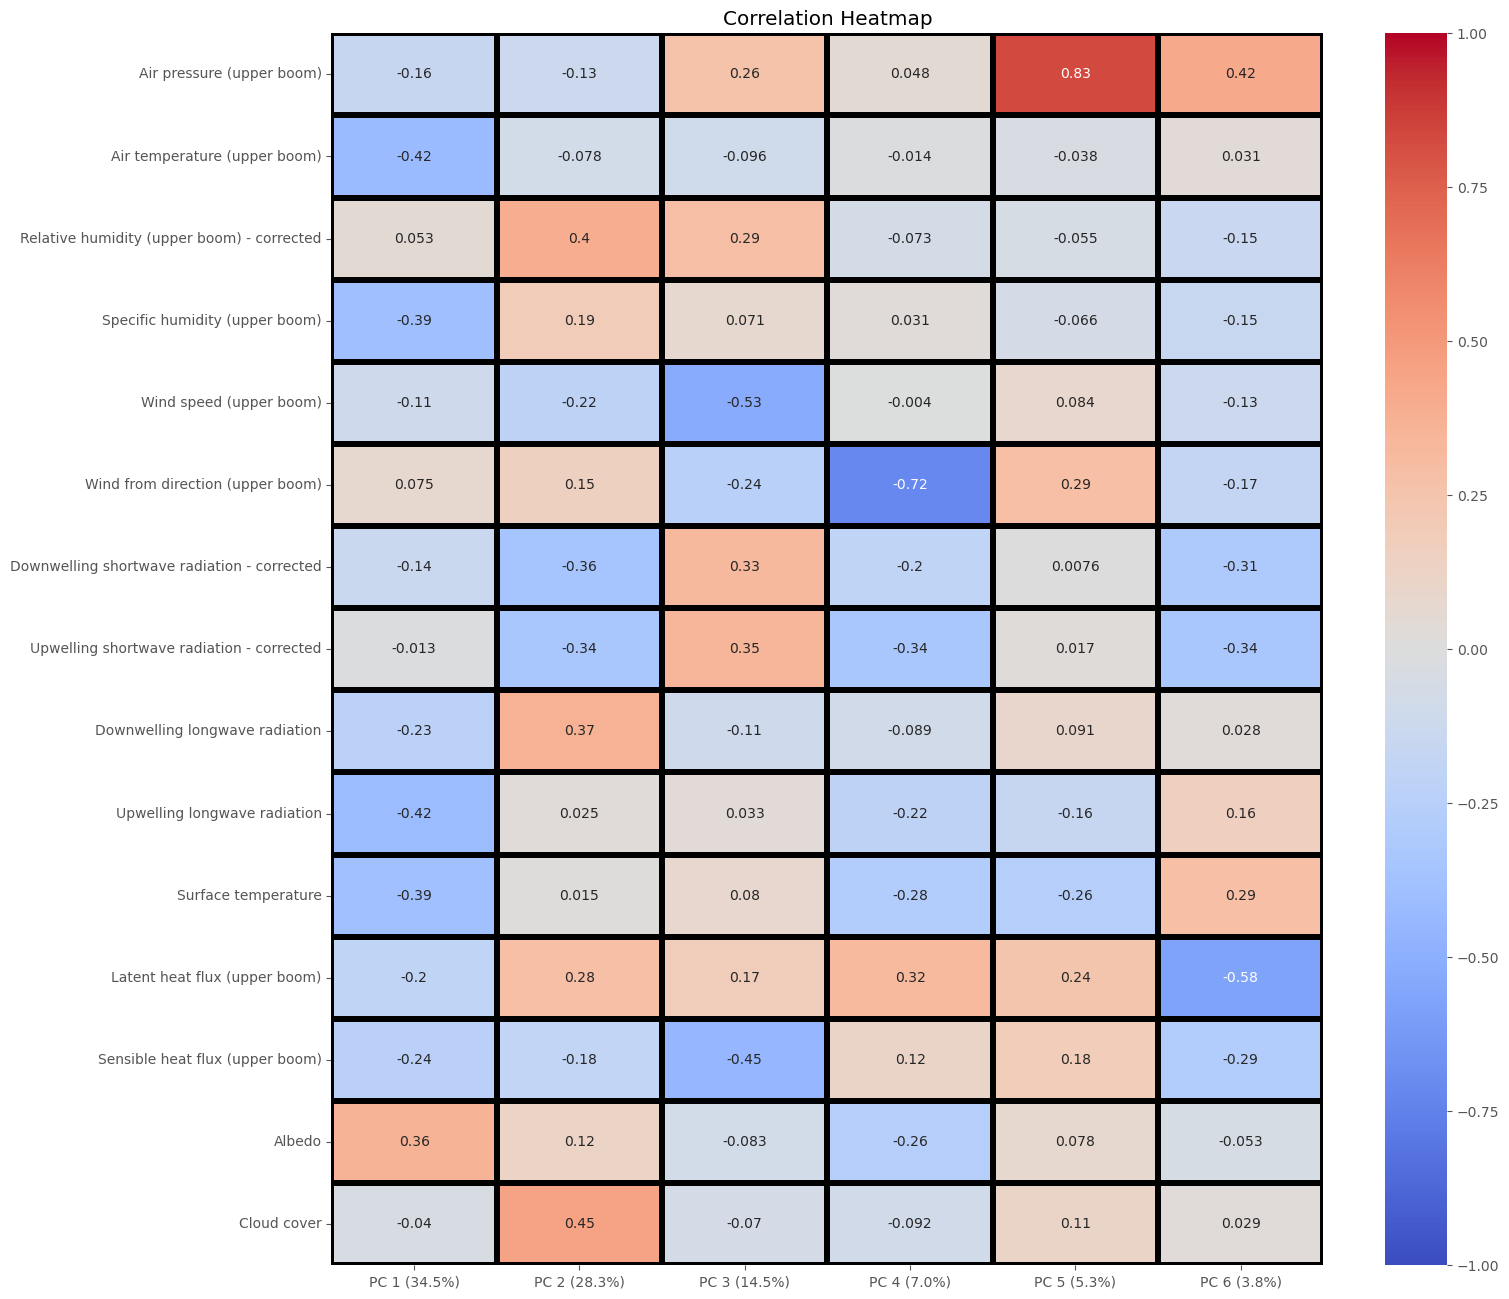

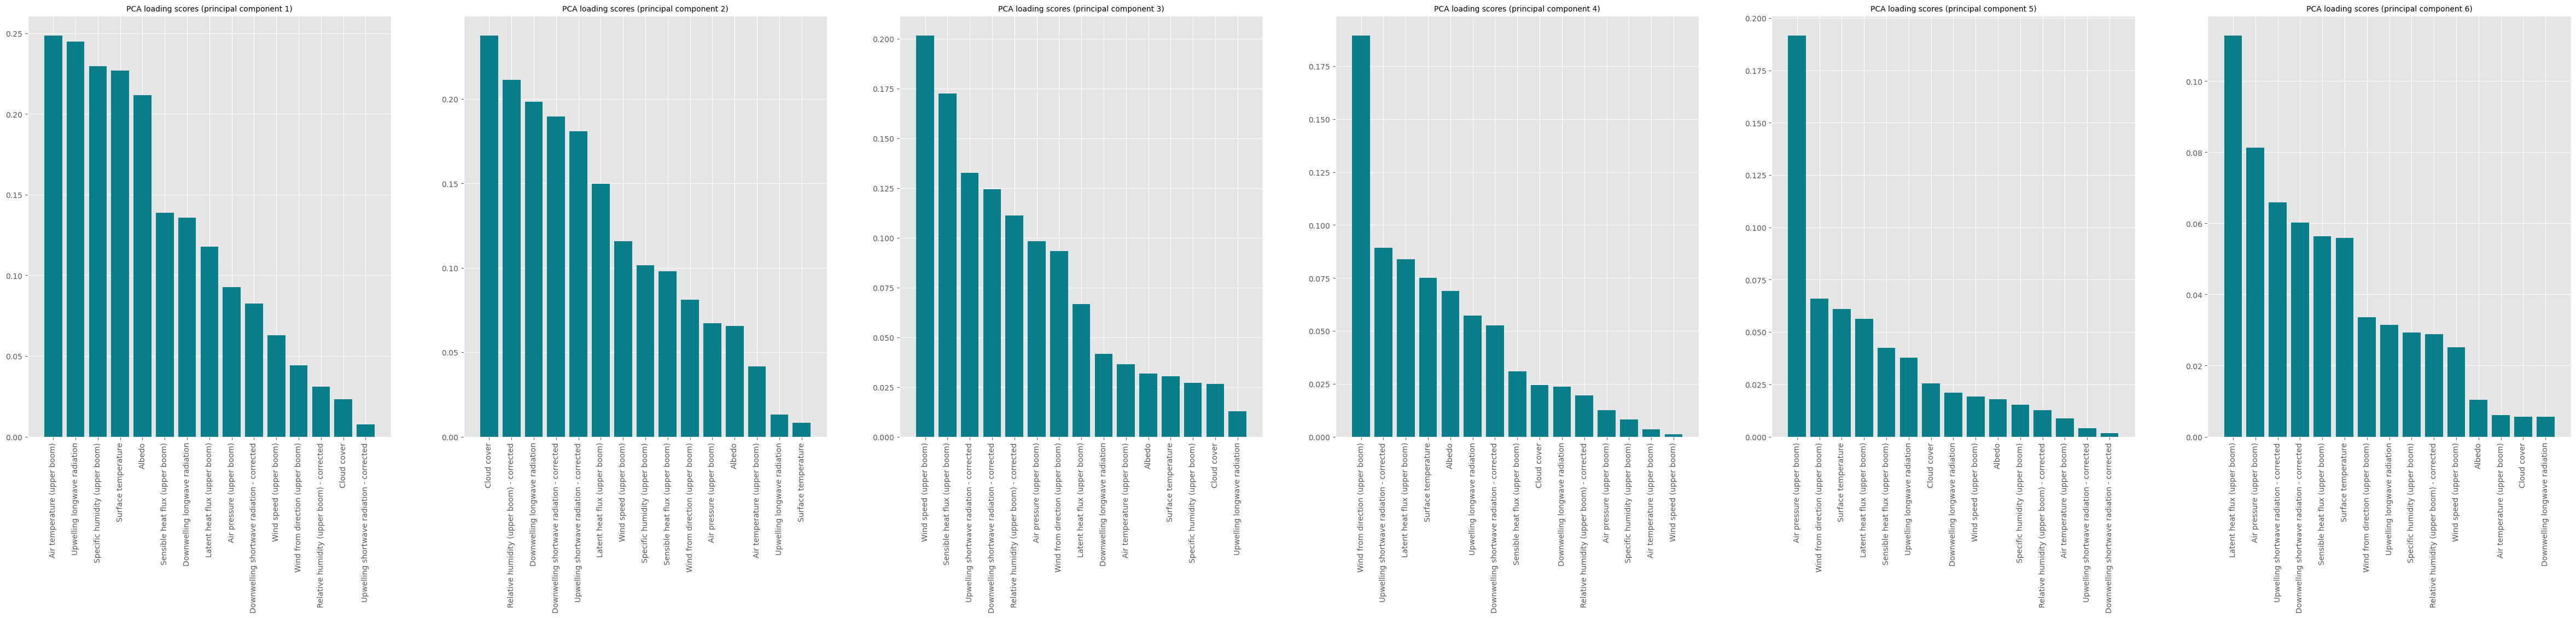

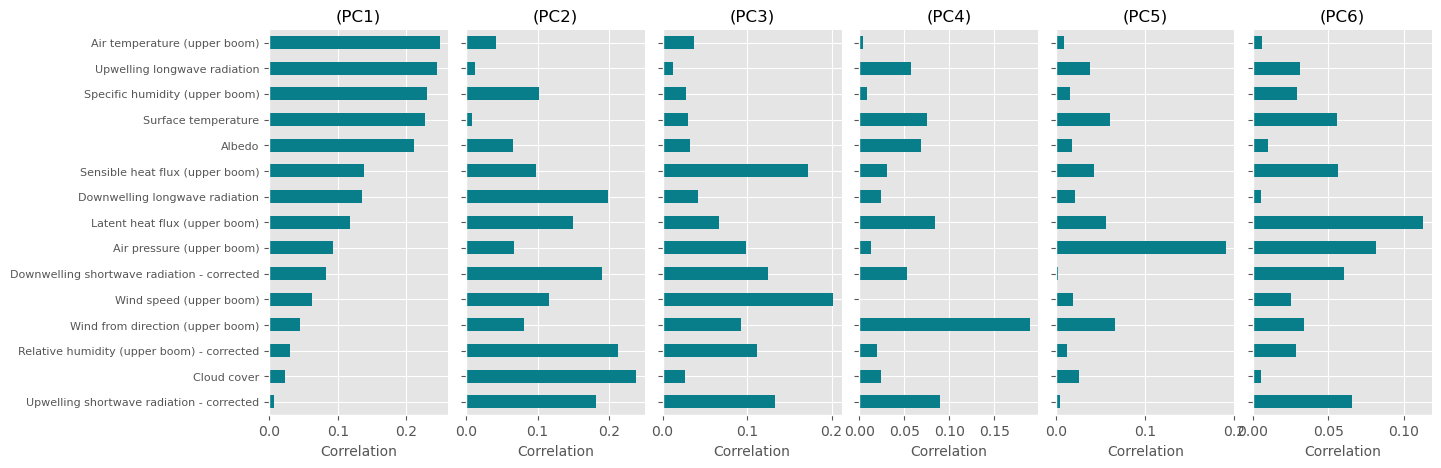

In [306]:
#Identify the optimal number of principal components 
optimal_component = np.argmax(cumulative_variance_explained >=0.9) + 1

variance_explained = [ppca.var_exp[i] - ppca.var_exp[i-1] for i in range(1, len(ppca.var_exp))]
variance_explained.insert(0,ppca.var_exp[0])


ppca_labels = {
    str(i):f"PC {i+1} ({var:.1f}%)"
    for i, var in enumerate(np.array(variance_explained)*100)
    }

ppca = PPCA()

X_train_ppca = ppca.fit(data = pp_X_train[num_cols].to_numpy(), d=optimal_component) 
X_train_ppca = ppca.transform(X_train_ppca)
X_test_ppca = ppca.transform(pp_X_test[num_cols].to_numpy())

# see how much features contribute to which components
ppca_df = pd.DataFrame(ppca.C,
                       columns = ppca_labels.values(),
                       index =pp_X_train[num_cols].columns)
ppca_df.head()

pca_heatmap(ppca_df)
pca_relationship(X_train_ppca)
pp_labels_vals = list(labels.values())
pp_loadings = pd.DataFrame(
    data=ppca.C * np.sqrt(variance_explained), 
    columns= pp_labels_vals,
    index=  pp_X_train[num_cols].columns
)
plot_pca_loadings(pp_labels_vals, pp_loadings)
plot_pca_vert(pp_labels_vals, pp_loadings, absolute=True)
